**TÍTULO**: Preprocessing          
**AUTOR**: Alexandre Saback  
**HISTÓRICO**: 
 - 12/2024: Criado durante o desenvolvimento da primeira tarefa AD-01.

**RESUMO**: 
> O objetivo dessa exploração inicial é verificar e validar os dados existentes, assim como, selecionar um conjunto inicial 
> de dados que podem ser utilizados futuramente em outras análises.

**DADOS DE ENTRADA**: 
- /sources/raw/*

**DADOS DE SAÍDA**:
- /sources/processed/*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from os.path import join
import re
import math

# Funções Úteis

In [2]:
def match_file_names(
    pattern: str,
    path: str):

    """
    Procura por arquivos que atendam ao padrão especificado e retorna uma lista com os seus caminhos.

    Parâmetros
    ----------
    pattern : str
        Padrão a ser procurado nos nomes dos arquivos.
    path : str
        Caminho inicial para a busca.

    Retorno
    -------
    matched_files : list[str]
        Uma lista com os caminhos dos arquivos que atendem ao padrão.
    """

    matched_files = []

    for root, _, files in os.walk(path):
        for file in files:
            if file.lower().endswith(".csv") and pattern.search(file):
                matched_files.append(os.path.join(root, file))

    return matched_files

In [3]:
def read_files(
    file_names: list[str],
    encoding: str = "utf8",
    delimiter: str = ","):

    """
    Lê arquivos CSV da lista de nomes de arquivos fornecida e retorna uma lista de DataFrames do pandas.

    Parâmetros
    ----------
    file_names : list[str]
        Lista de caminhos de arquivos a serem lidos.
    encoding : str, opcional
        Encoding a ser usado ao ler os arquivos. O padrão é "utf8".
    delimiter : str, opcional
        Delimitador a ser usado ao ler os arquivos. O padrão é ",".

    Retorno
    -------
    df_list : list[pd.DataFrame]
        Uma lista de DataFrames do pandas lidos dos arquivos especificados.
    """

    df_list = []
    for file_name in file_names:

        with open(file_name, "r", encoding="latin-1") as file:
            lines = file.readlines()
        
        header_index = next(i for i, line in enumerate(lines) if line.startswith("Data"))

        try:
            df = pd.read_csv(
                file_name, 
                skiprows=header_index,
                encoding=encoding, 
                delimiter=delimiter)
            df = df.drop(columns=["Unnamed: 19"])
            df_list.append(df)
        except Exception as e:
            print(f"Exception {e} on {file_name}")

        
    return df_list

In [4]:
def replace_comma(value):

    """
    Substitui vírgulas por pontos em valores numéricos para que o pandas possa ler como float.

    Parâmetros
    ----------
    value : any
        Valor a ser modificado.

    Retorno
    -------
    any
        Valor modificado.
    """

    if isinstance(value, str): 
        return pd.to_numeric(value.replace(",", "."), errors='coerce') 
    
    return value 

In [5]:
def plot_grouped_data(
    df: pd.DataFrame,
    group_col: str,
    value_col: str,
    xticks_rotation: int = 0,
    apply_log: bool = False):

    """
    Plota dados agrupados do DataFrame fornecido.

    Parâmetros
    ----------
    df: pd.DataFrame
        Os dados a serem plotados.
    group_col: str
        O nome da coluna a ser agrupada.
    value_col: str
        O nome da coluna para os valores a serem plotados.
    bar: bool, opcional
        Se True, plota gráficos de barras. O padrão é False.
    x_axis: bool, opcional
        Se True, plota no eixo x. O padrão é False.
    hue_col: str, opcional
        O nome da coluna para o hue. O padrão é None.
    xticks_rotation: int, opcional
        Ângulo de rotação para x-ticks. O padrão é 0.
    apply_log: bool, opcional
        Se True, aplica transformação de log aos valores. O padrão é False.
    """


    if apply_log:
        df[value_col] = np.log(df[value_col])

    grouped_data = list(df.groupby(by=group_col))

    num_plots = len(grouped_data)
    num_cols = 2
    num_rows = math.ceil(num_plots / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 6 * num_rows), sharey=True)
    axes = axes.reshape(-1, num_cols) if num_rows > 1 else [axes]

    for idx, (group, df_values) in enumerate(grouped_data):
        row, col = divmod(idx, num_cols)
        ax = axes[row][col]
        
        sns.lineplot(df_values[value_col], ax=ax)
        
        plt.suptitle(value_col)
        ax.set_title(group)
        plt.xticks(rotation=xticks_rotation)

    for idx in range(num_plots, num_rows * num_cols):
        row, col = divmod(idx, num_cols)
        fig.delaxes(axes[row][col])

    plt.tight_layout()
    plt.show()

# Coleta de Dados

In [6]:
MODULE_PATH = Path().absolute().parent
DATA_PATH = join(MODULE_PATH, "sources/raw")

In [7]:
pattern = re.compile(r"BELO[\s_\-]?HORIZONTE|PAMPULHA", re.IGNORECASE)
matched_files = match_file_names(pattern=pattern, path=DATA_PATH)

In [8]:
df_list = read_files(file_names=matched_files, encoding="latin-1", delimiter=";")

# Pré-processamento

In [9]:
for df in df_list:
    df["Hora UTC"] = df["Hora UTC"].str.replace(" UTC", "")
    df["Datetime"] = pd.to_datetime(df["Data"] + " " + df["Hora UTC"], format="%Y/%m/%d %H%M")

    df.rename(columns={"RADIACAO GLOBAL (KJ/m²)": "RADIACAO GLOBAL (Kj/m²)"}, inplace=True)

    for col in [col for col in df.columns if col not in ["Data", "Hora UTC", "Datetime"]]:
        df[col] = df[col].apply(replace_comma)

In [10]:
df_years_dict = {}

i = 0
for first_file_name, first_df in zip(matched_files, df_list):
    first_file_year = first_file_name.split("\\")[-2]

    common_year_df_list = [first_df]
    for second_file_name, second_df in zip(matched_files[i+1:], df_list[i+1:]):
        second_file_year = second_file_name.split("\\")[-2]

        if first_file_year == second_file_year:
            common_year_df_list.append(second_df)

    if first_file_year not in df_years_dict.keys():
        df_years_dict[first_file_year] = common_year_df_list
    i+=1

In [11]:
combined_df_by_year_dict = {}
for year, year_df_list in df_years_dict.items():

    year_df_list = [df.set_index("Datetime").asfreq("h").reset_index() for df in year_df_list]

    combined_df = pd.concat(year_df_list)
    combined_df = combined_df.drop(columns=["Data", "Hora UTC"])
    result = combined_df.groupby("Datetime").mean().reset_index()

    combined_df_by_year_dict[year] = result

In [12]:
complete_df = pd.concat(list(combined_df_by_year_dict.values())).set_index("Datetime").asfreq("h")

In [13]:
complete_df["Ano"] = list(complete_df.reset_index()["Datetime"].dt.year)

In [14]:
complete_df

PRECIPITAÇÃO TOTAL, HORÁRIO (mm)  \
Datetime                                                
2019-01-01 00:00:00                               0.0   
2019-01-01 01:00:00                               0.0   
2019-01-01 02:00:00                               0.0   
2019-01-01 03:00:00                               0.0   
2019-01-01 04:00:00                               0.0   
...                                               ...   
2024-12-31 19:00:00                               0.0   
2024-12-31 20:00:00                               0.0   
2024-12-31 21:00:00                               0.0   
2024-12-31 22:00:00                               0.0   
2024-12-31 23:00:00                               0.0   

                     PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)  \
Datetime                                                                     
2019-01-01 00:00:00                                             899.80       
2019-01-01 01:00:00                                             900.35       
2019-01-01 02:00:00                                             900.45       
2019-01-01 03:00:00                                             899.75       
2019-01-01 04:00:00                                             899.80       
...                                                                ...       
2024-12-31 19:00:00                                             898.15       
2024-12-31 20:00:00                                             897.65       
2024-12-31 21:00:00                                             898.10       
2024-12-31 22:00:00                                             898.65       
2024-12-31 23:00:00                                             899.35       

                     PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)  \
Datetime                                                               
2019-01-01 00:00:00                                           899.80   
2019-01-01 01:00:00                                           900.35   
2019-01-01 02:00:00                                           900.55   
2019-01-01 03:00:00                                           900.45   
2019-01-01 04:00:00                                           899.85   
...                                                              ...   
2024-12-31 19:00:00                                           898.90   
2024-12-31 20:00:00                                           898.15   
2024-12-31 21:00:00                                           898.10   
2024-12-31 22:00:00                                           898.65   
2024-12-31 23:00:00                                           899.35   

                     PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)  \
Datetime                                                                
2019-01-01 00:00:00                                            899.15   
2019-01-01 01:00:00                                            899.80   
2019-01-01 02:00:00                                            900.30   
2019-01-01 03:00:00                                            899.75   
2019-01-01 04:00:00                                            899.55   
...                                                               ...   
2024-12-31 19:00:00                                            898.15   
2024-12-31 20:00:00                                            897.55   
2024-12-31 21:00:00                                            897.60   
2024-12-31 22:00:00                                            898.10   
2024-12-31 23:00:00                                            898.65   

                     RADIACAO GLOBAL (Kj/m²)  \
Datetime                                       
2019-01-01 00:00:00                      NaN   
2019-01-01 01:00:00                      NaN   
2019-01-01 02:00:00                      NaN   
2019-01-01 03:00:00                      NaN   
2019-01-01 04:00:00                      NaN   
...                                      

# Visualizando Séries Temporais

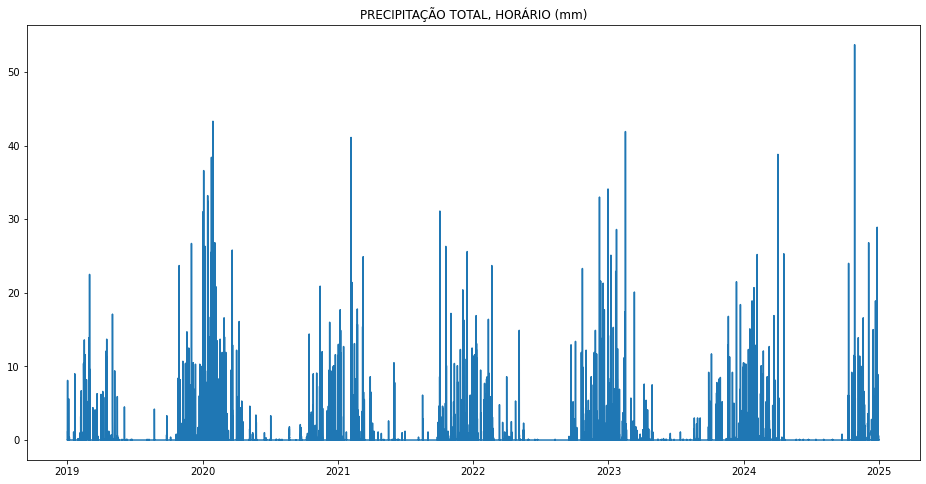

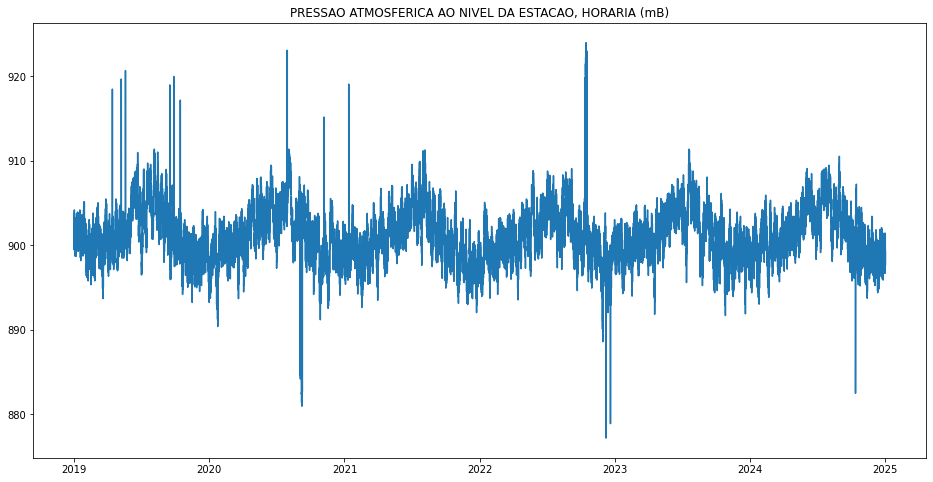

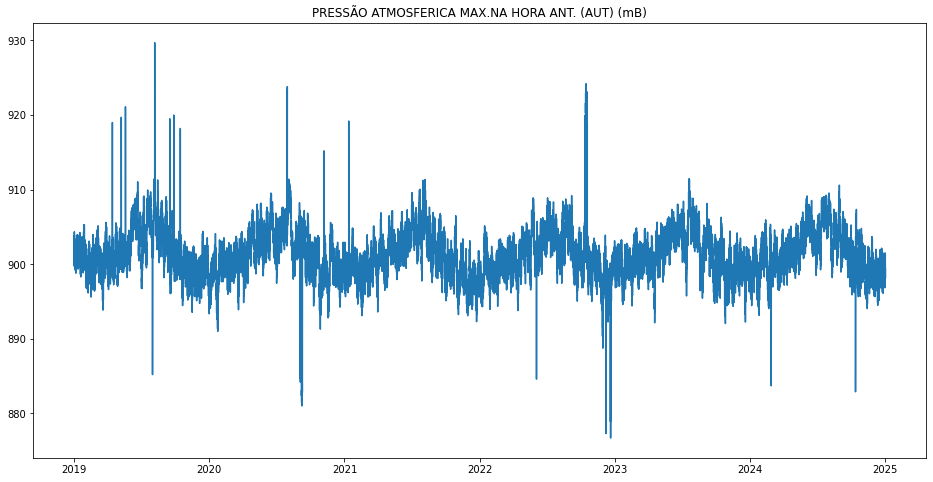

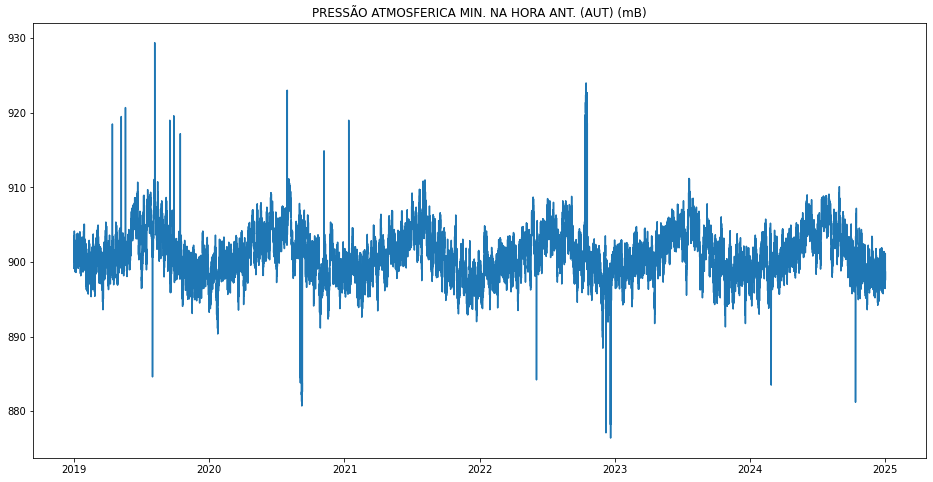

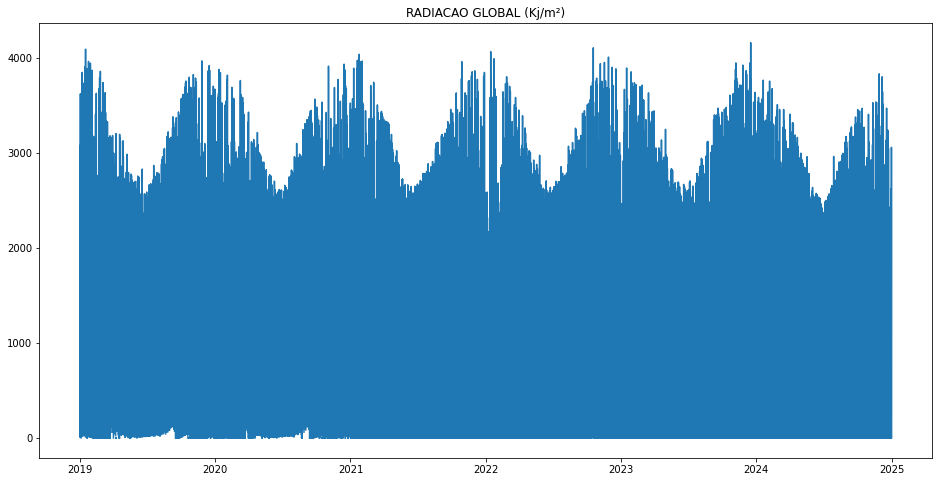

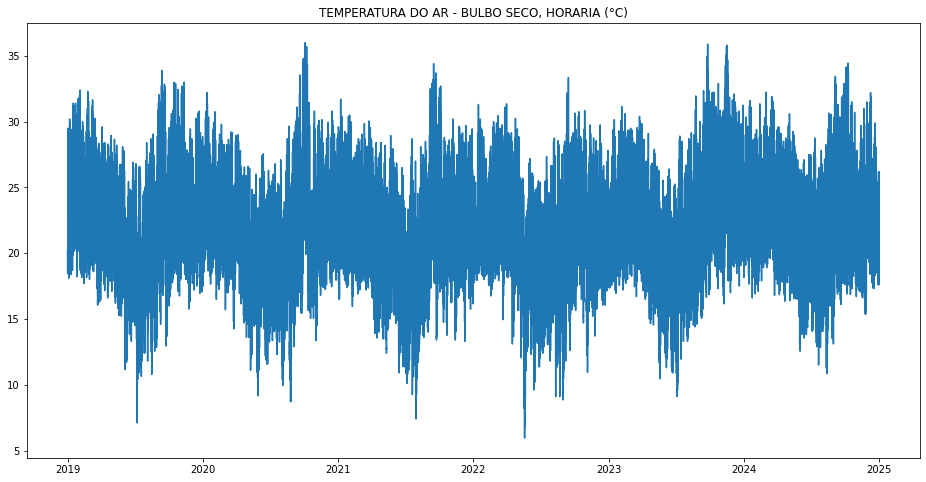

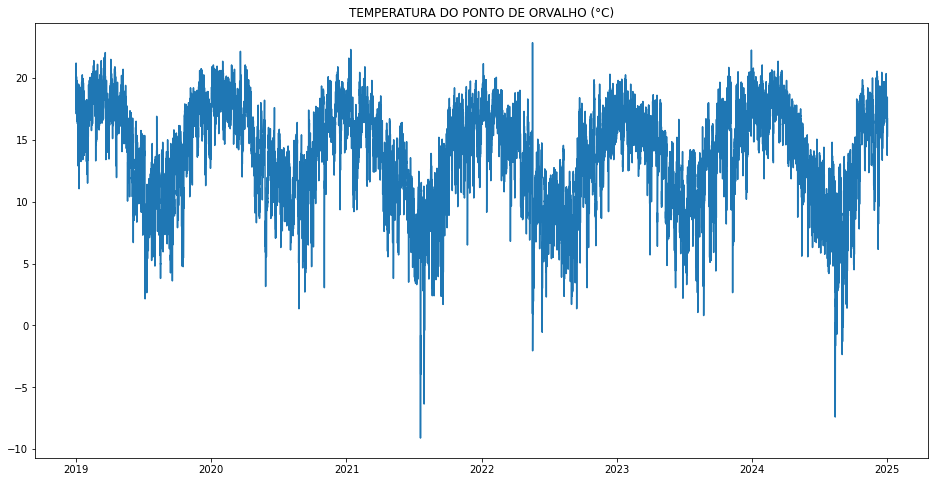

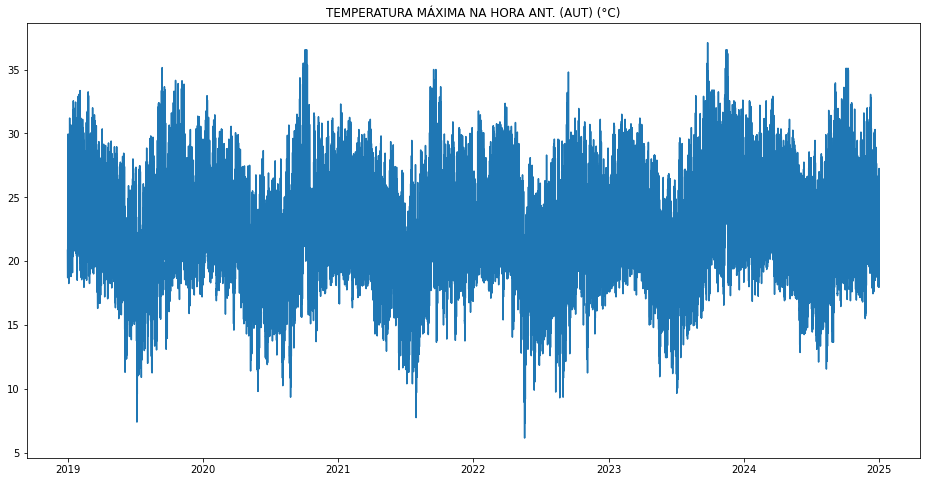

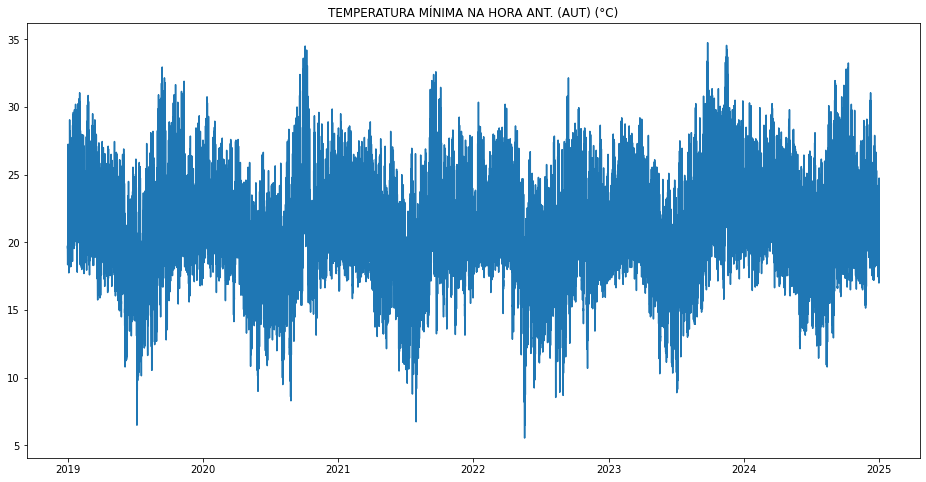

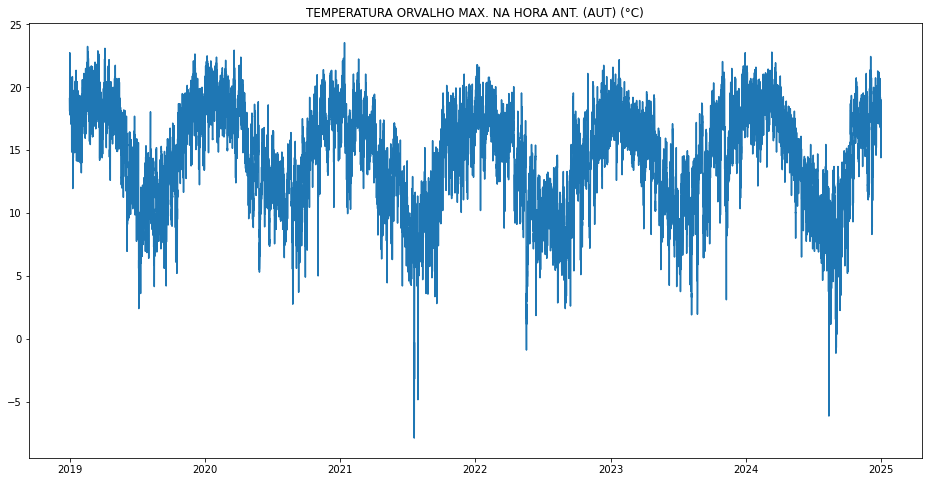

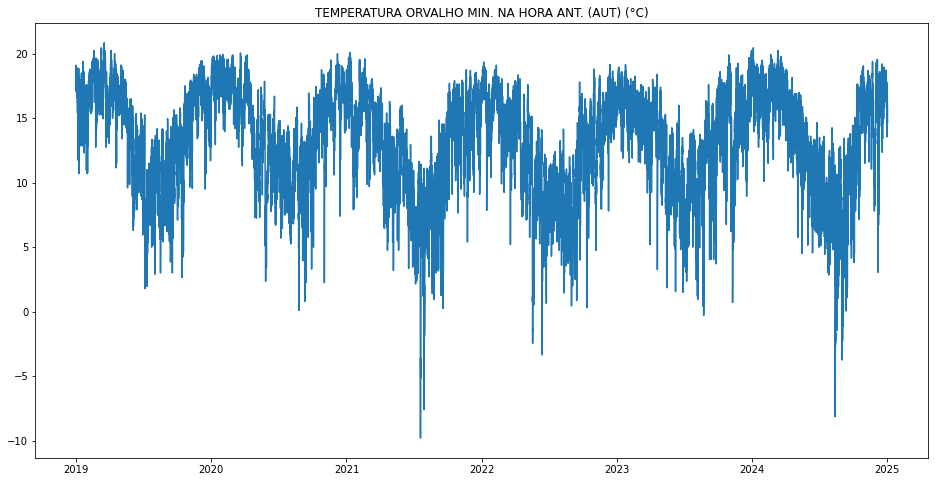

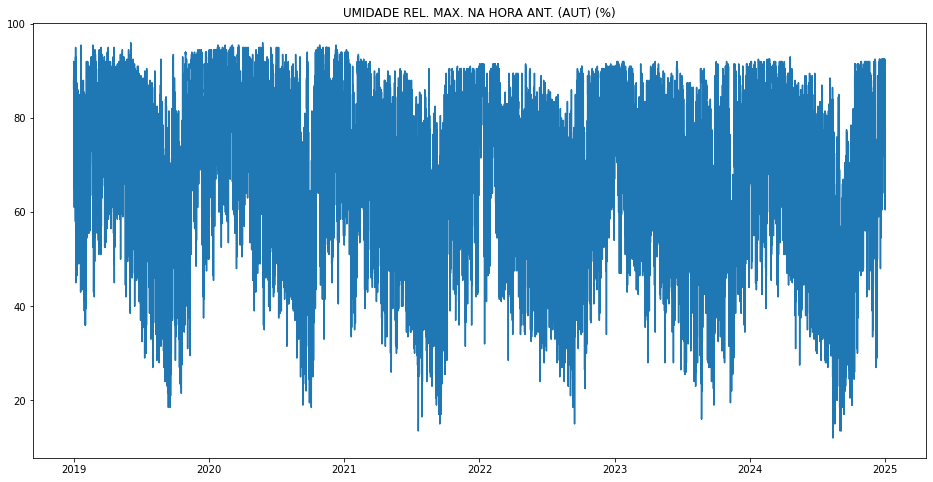

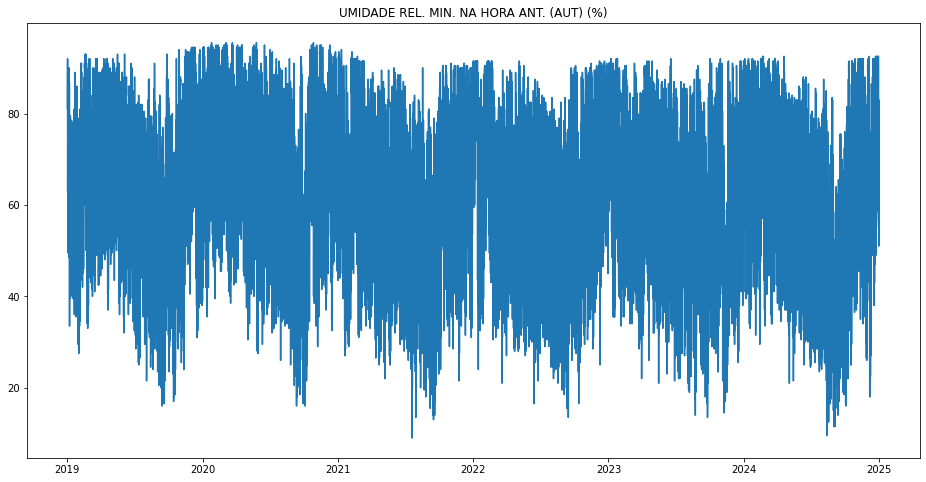

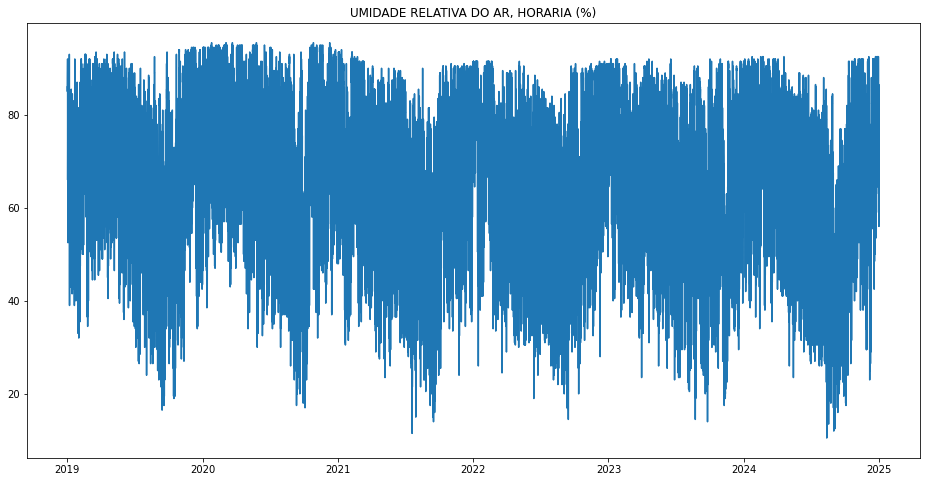

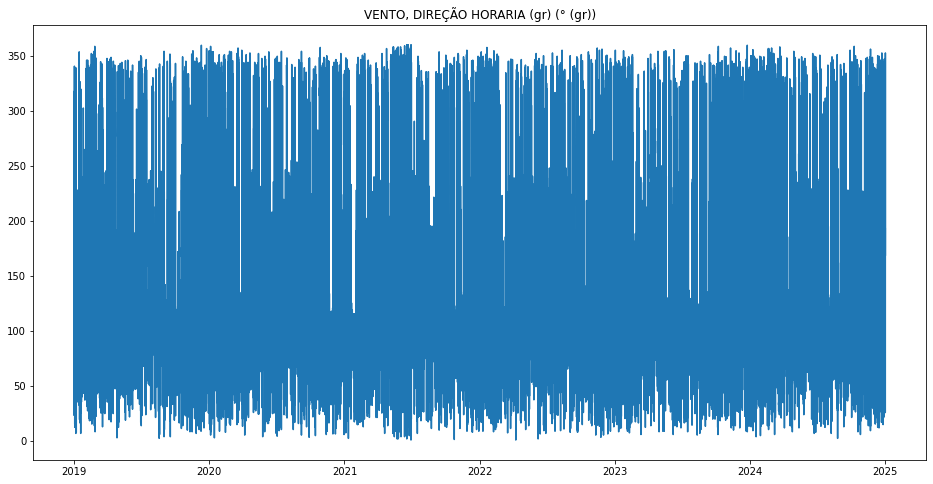

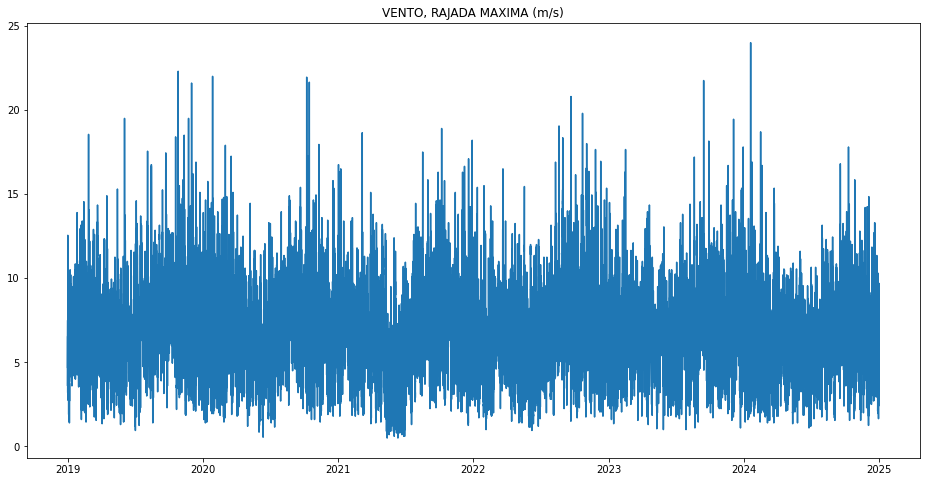

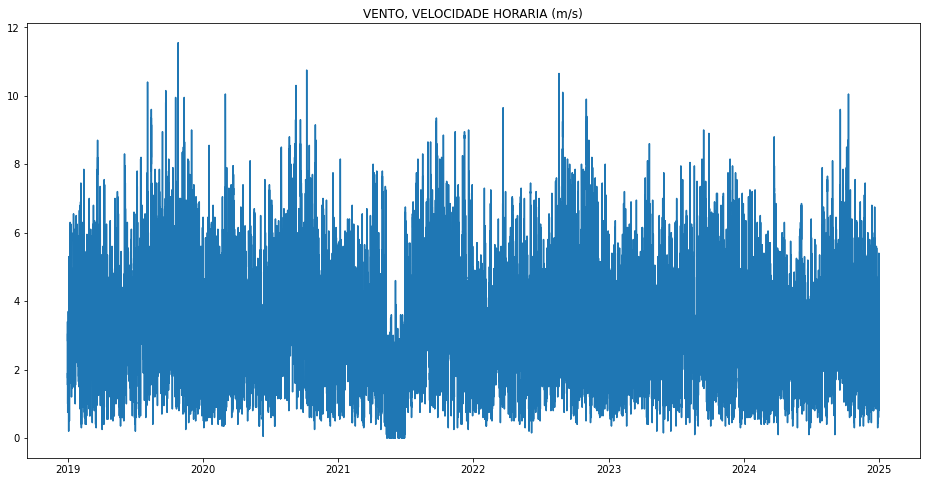

In [15]:
for col in complete_df.columns.tolist()[:-1]:
    fig, ax = plt.subplots(figsize=(16,8))
    plt.plot(complete_df[col])
    plt.title(col)
    plt.show()

## Separando por Ano

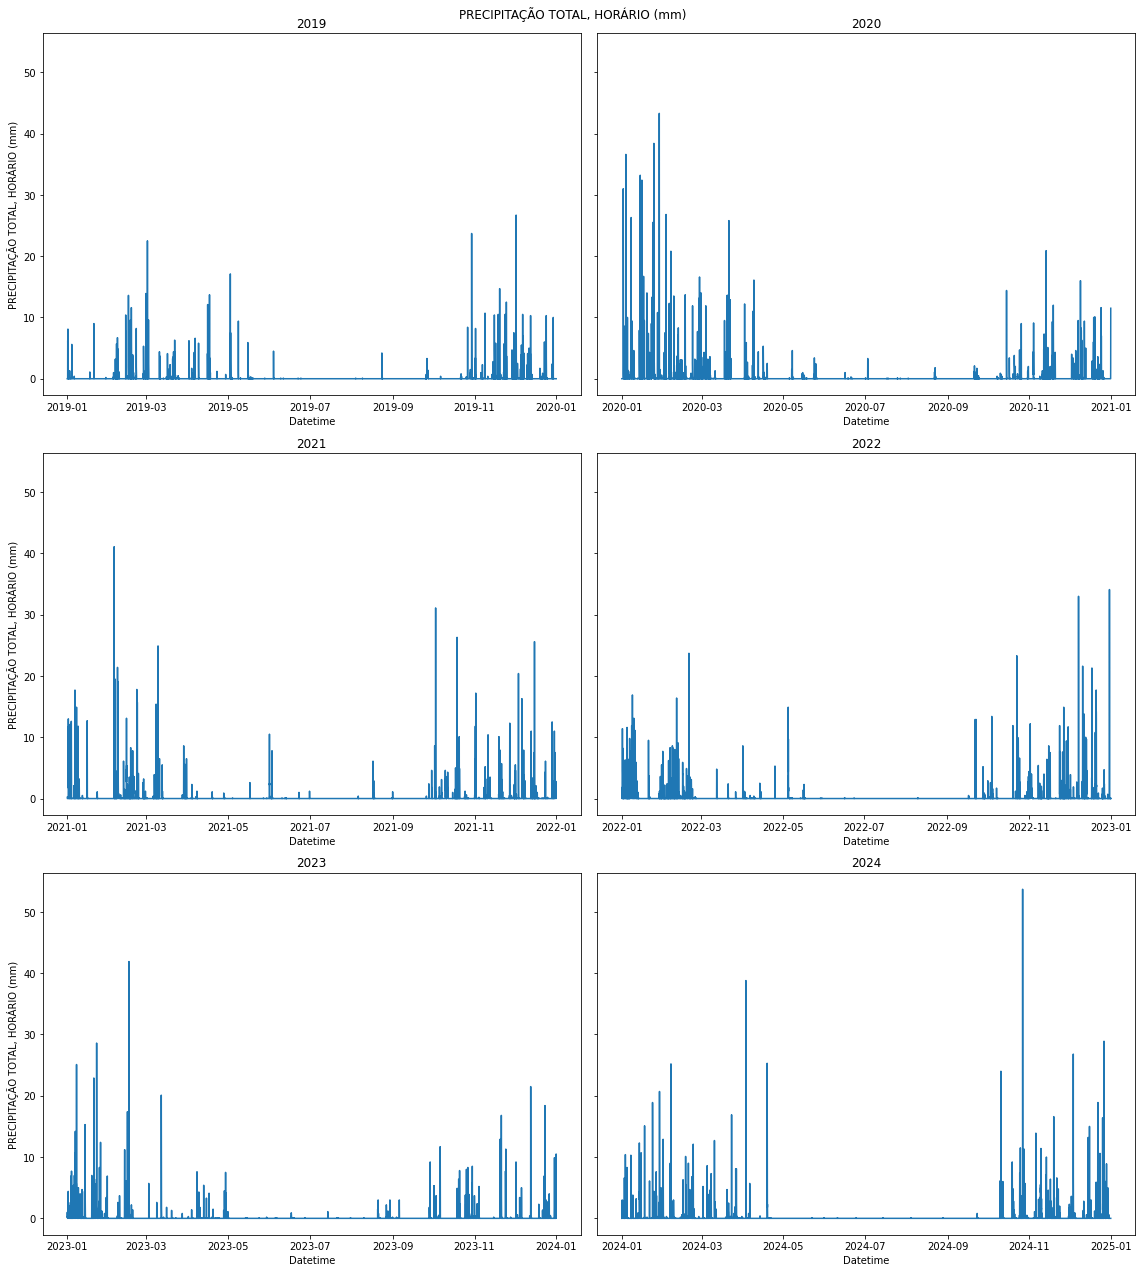

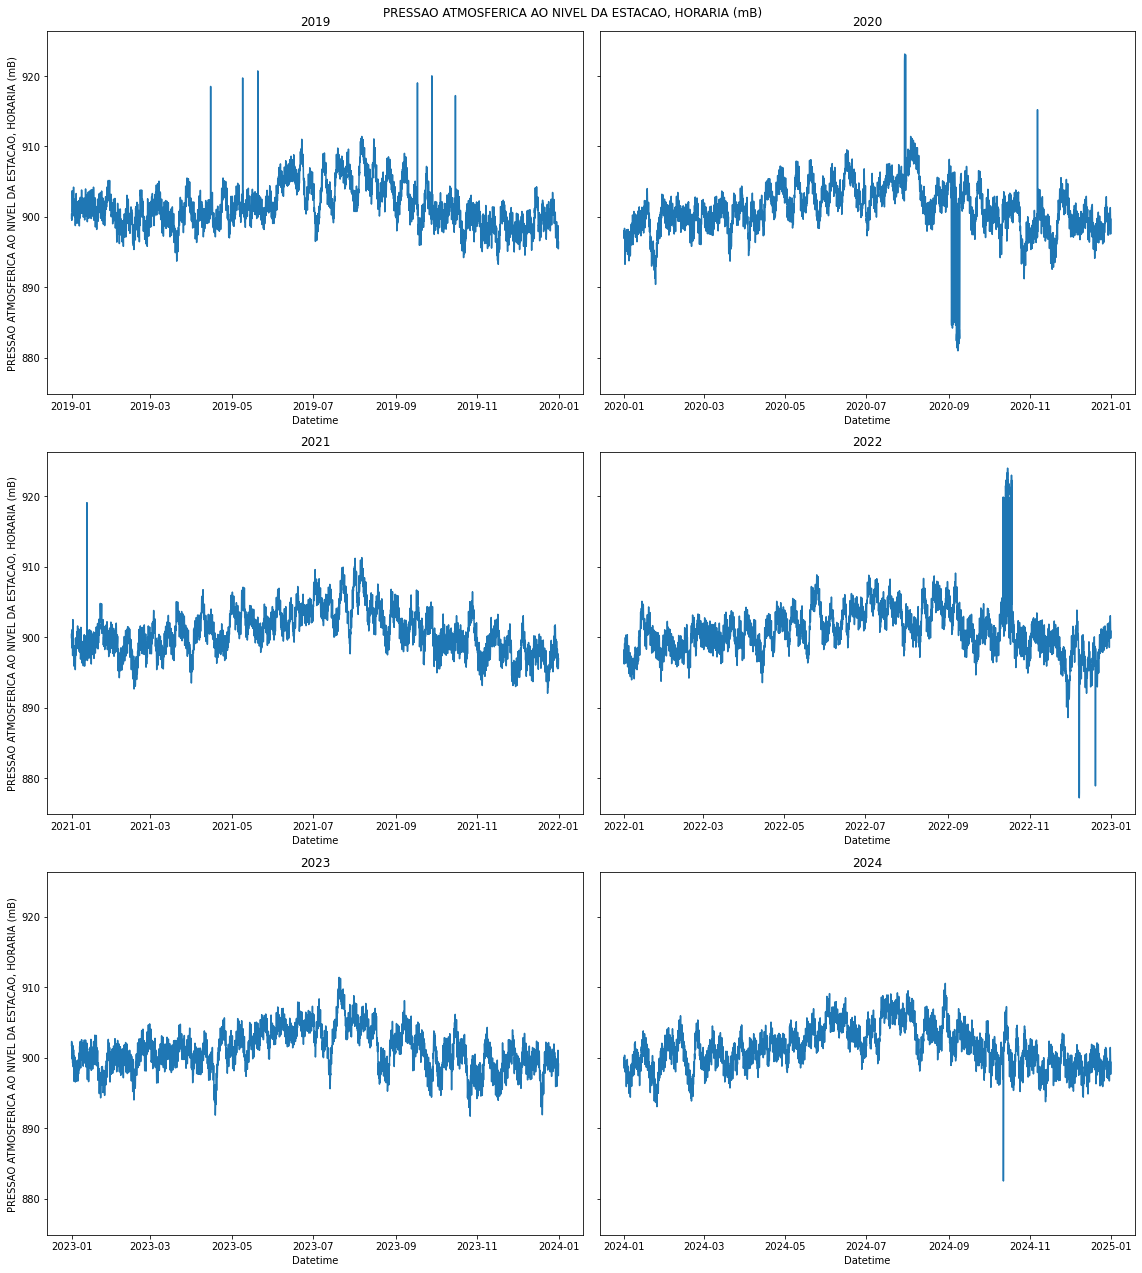

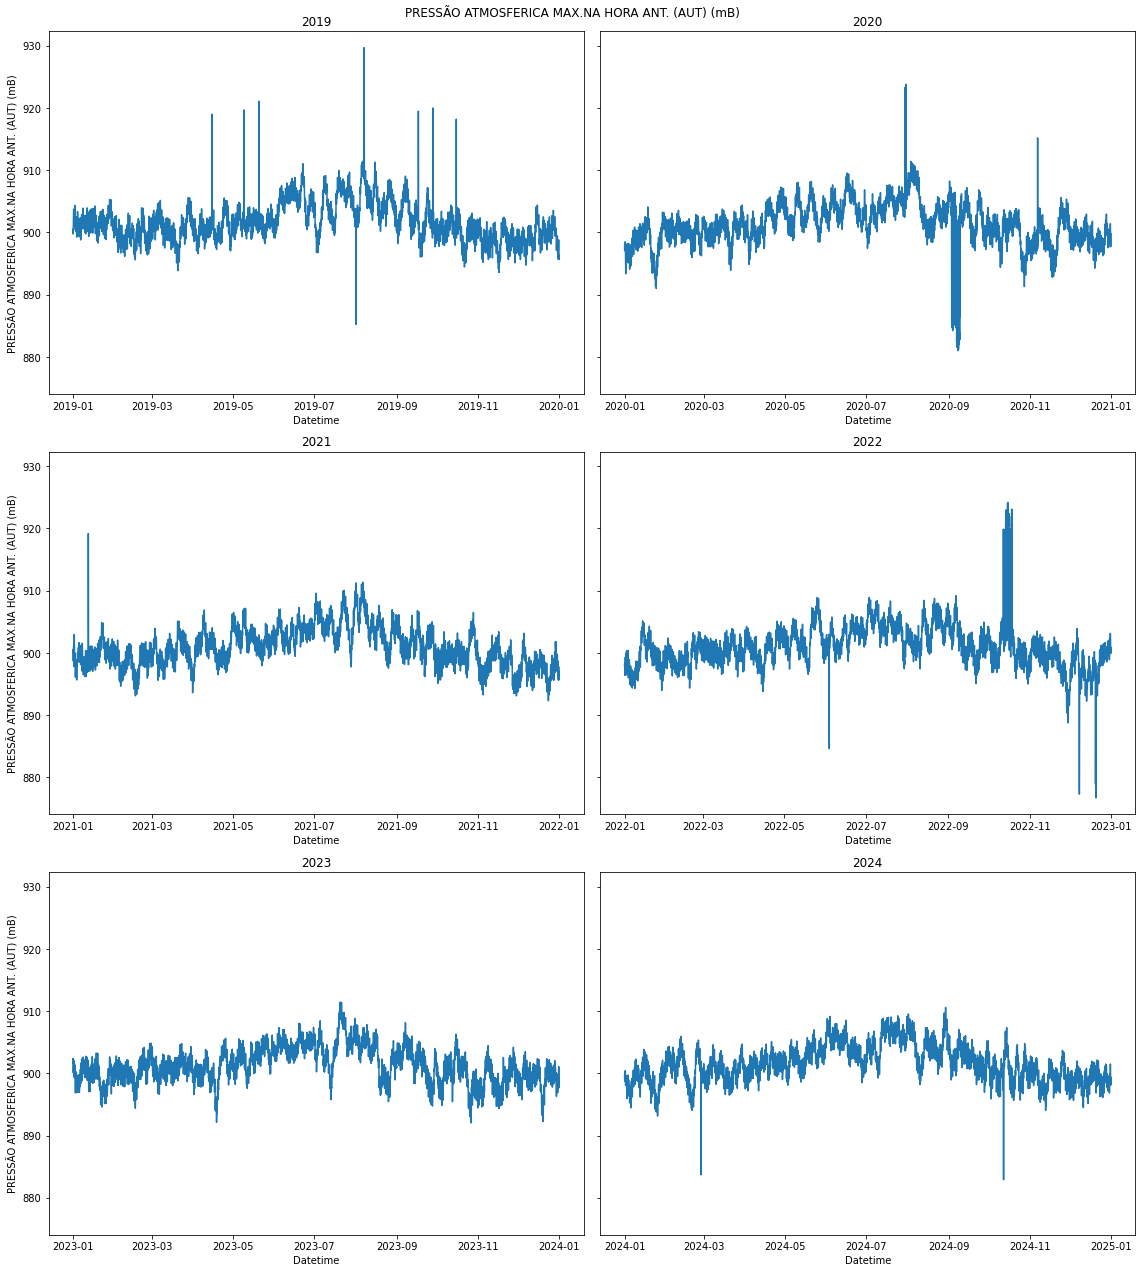

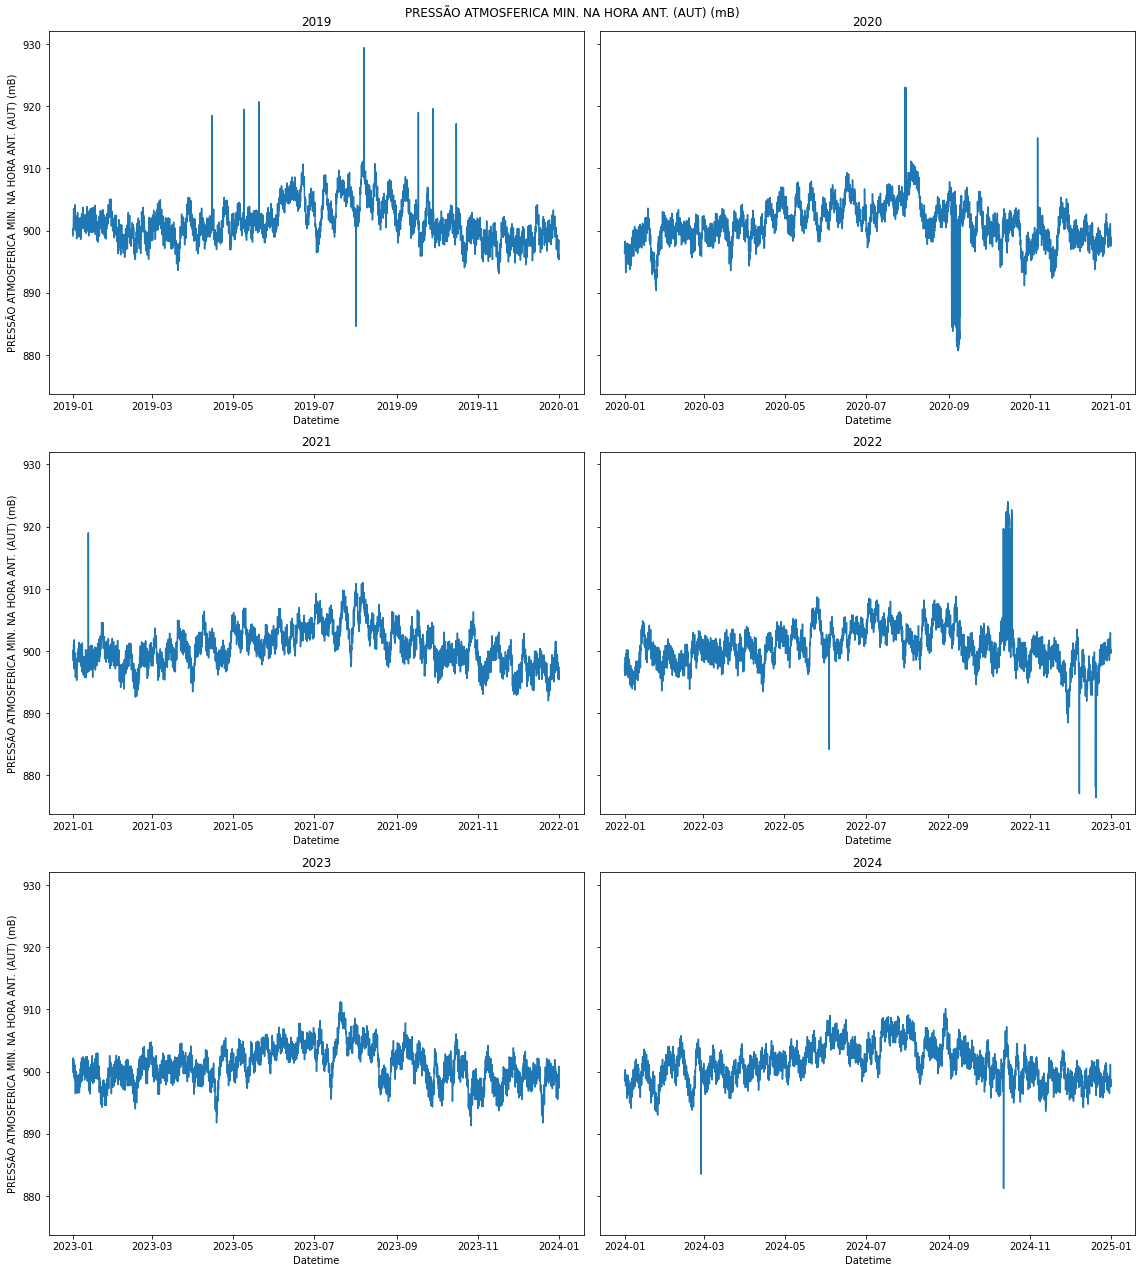

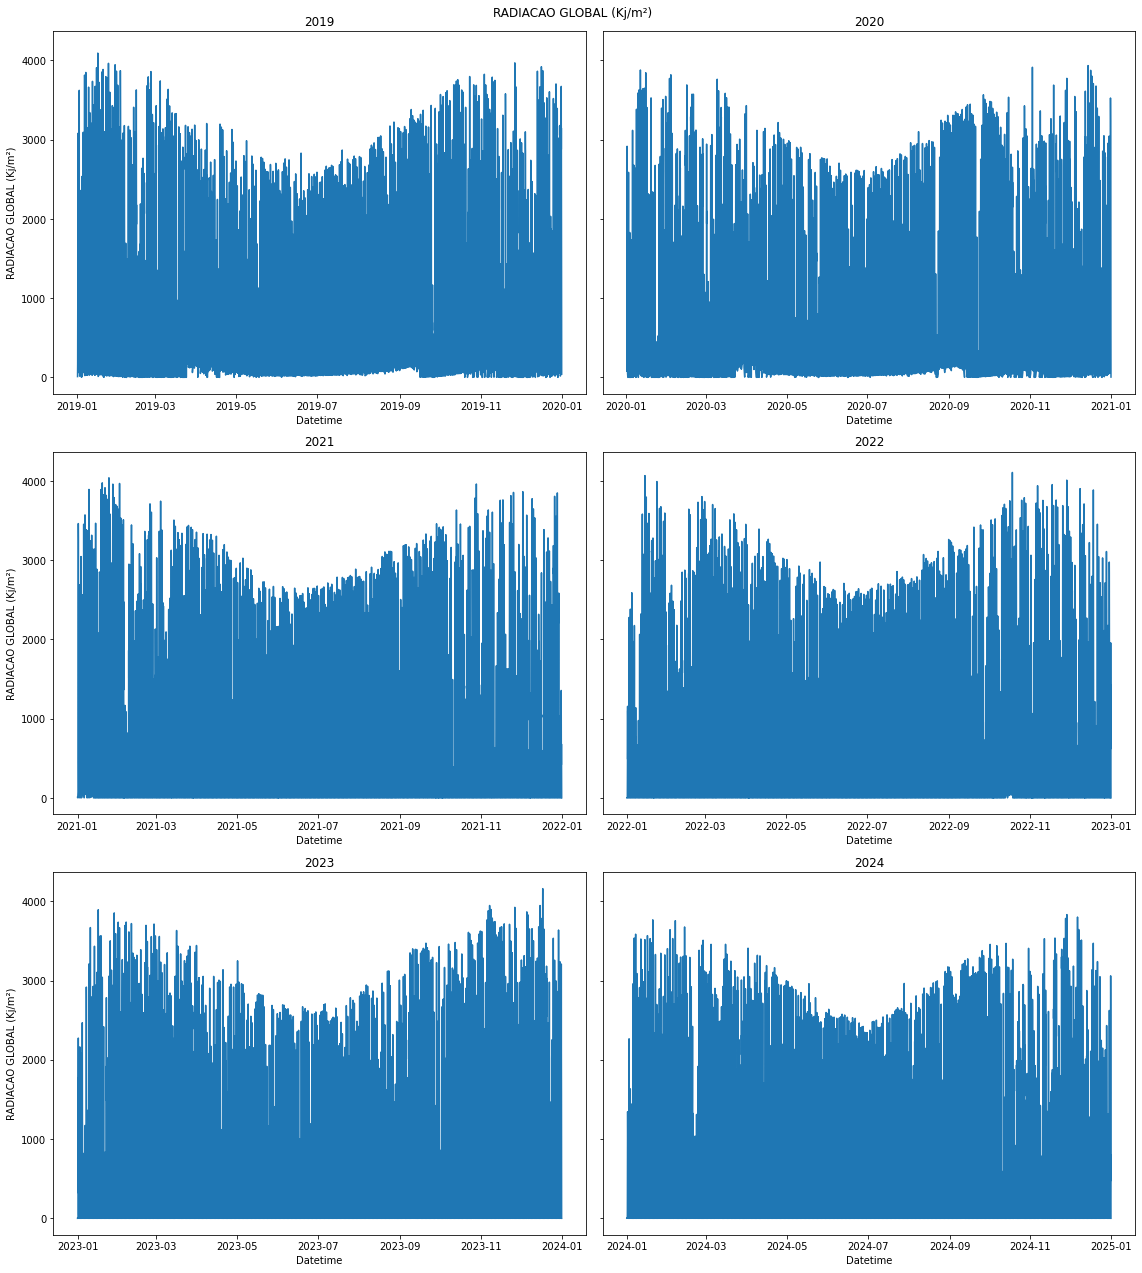

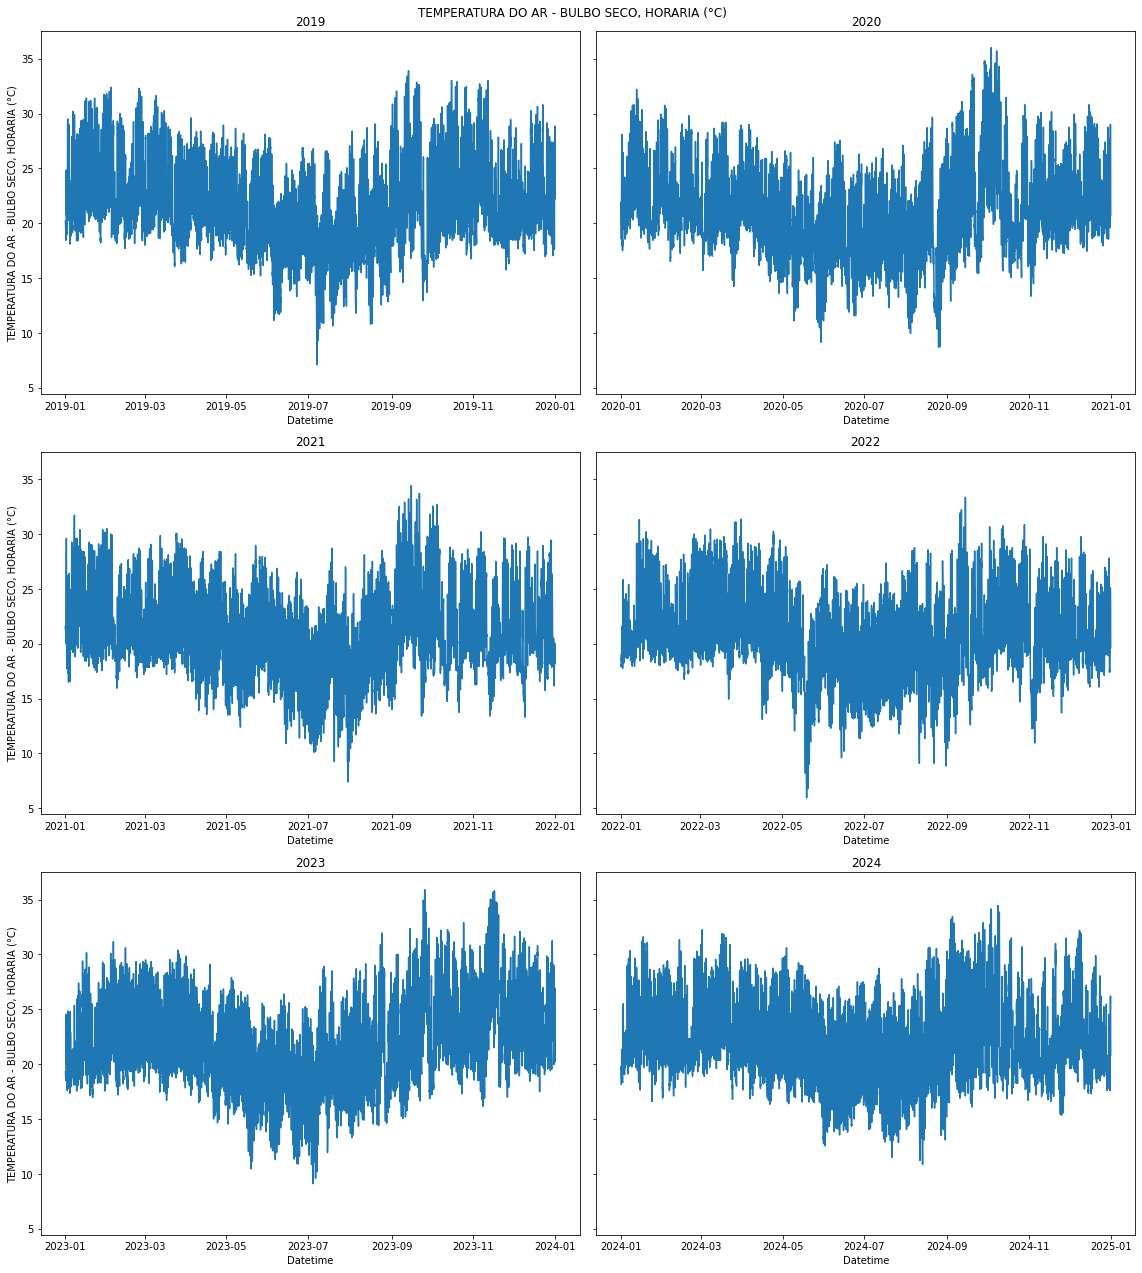

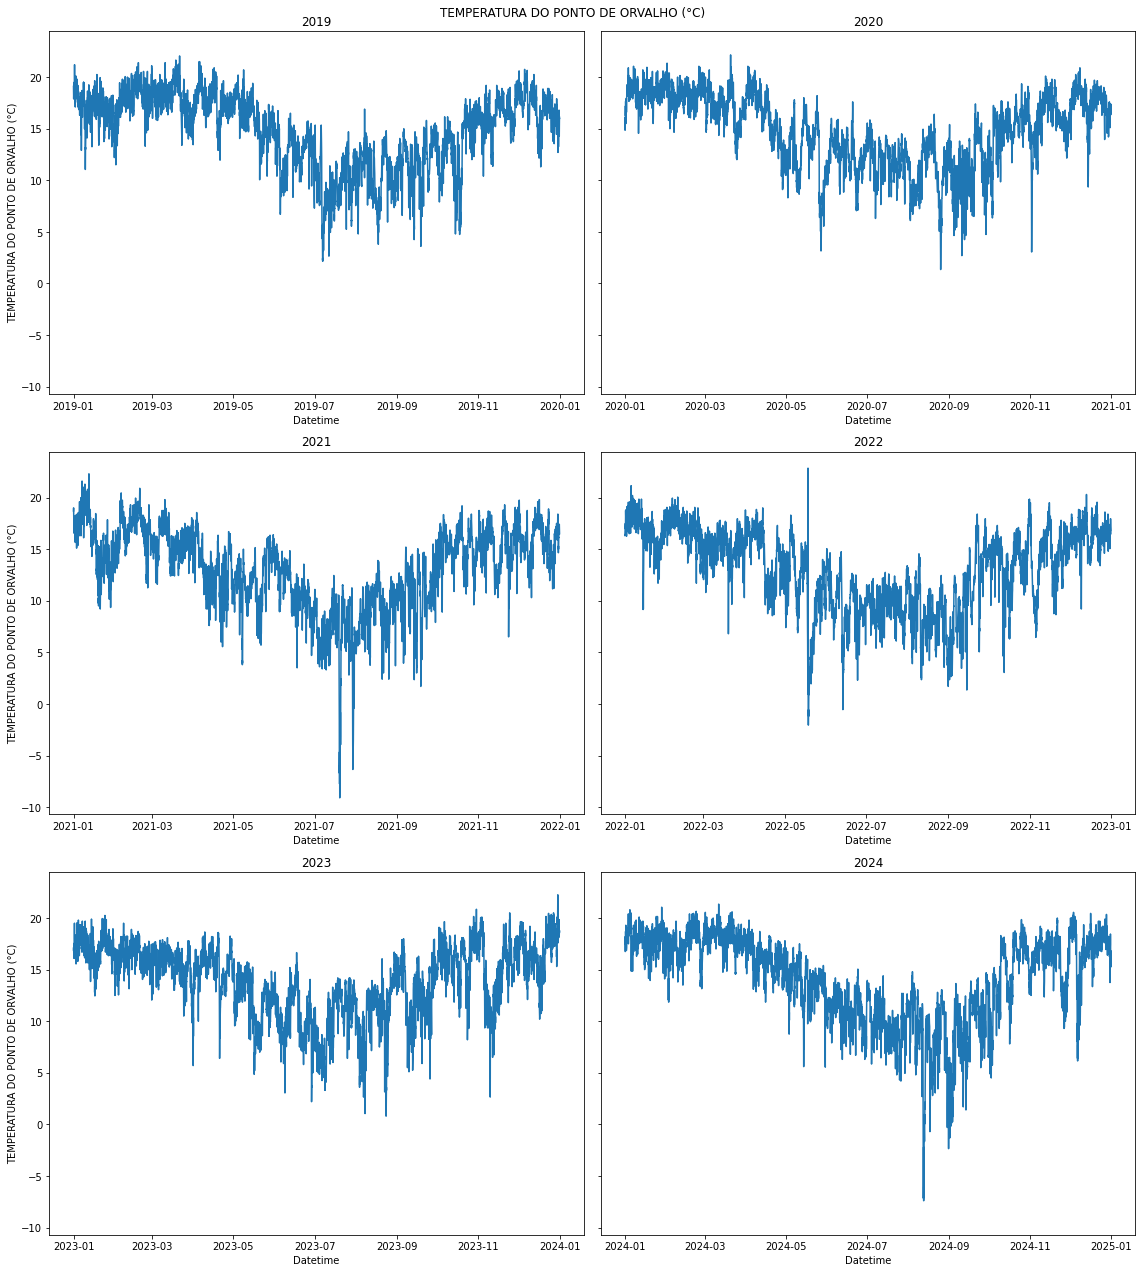

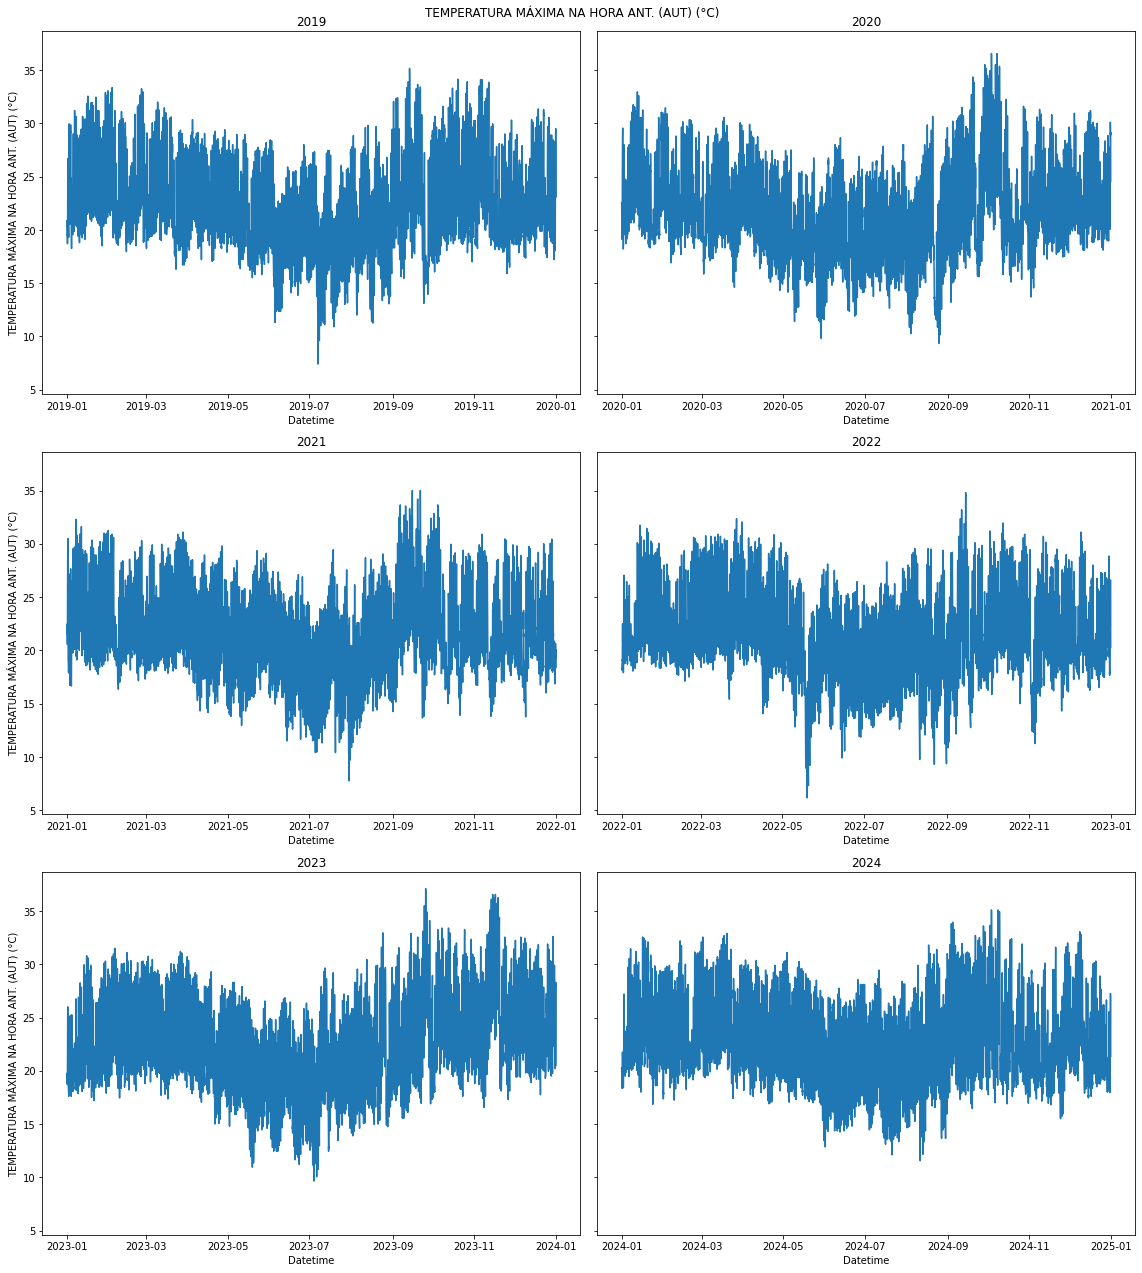

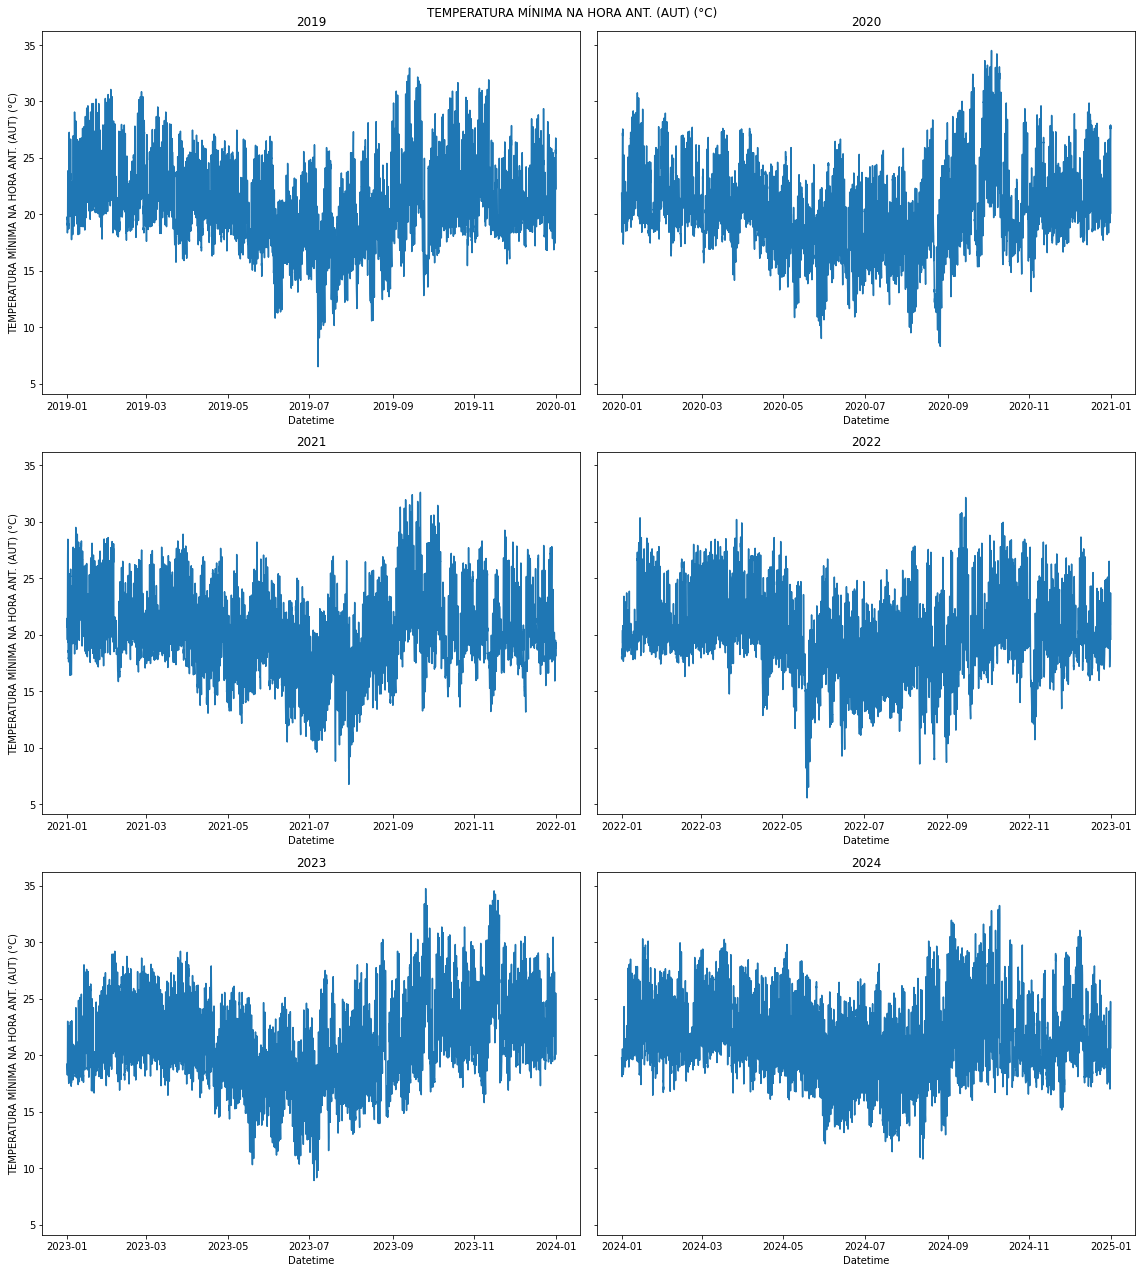

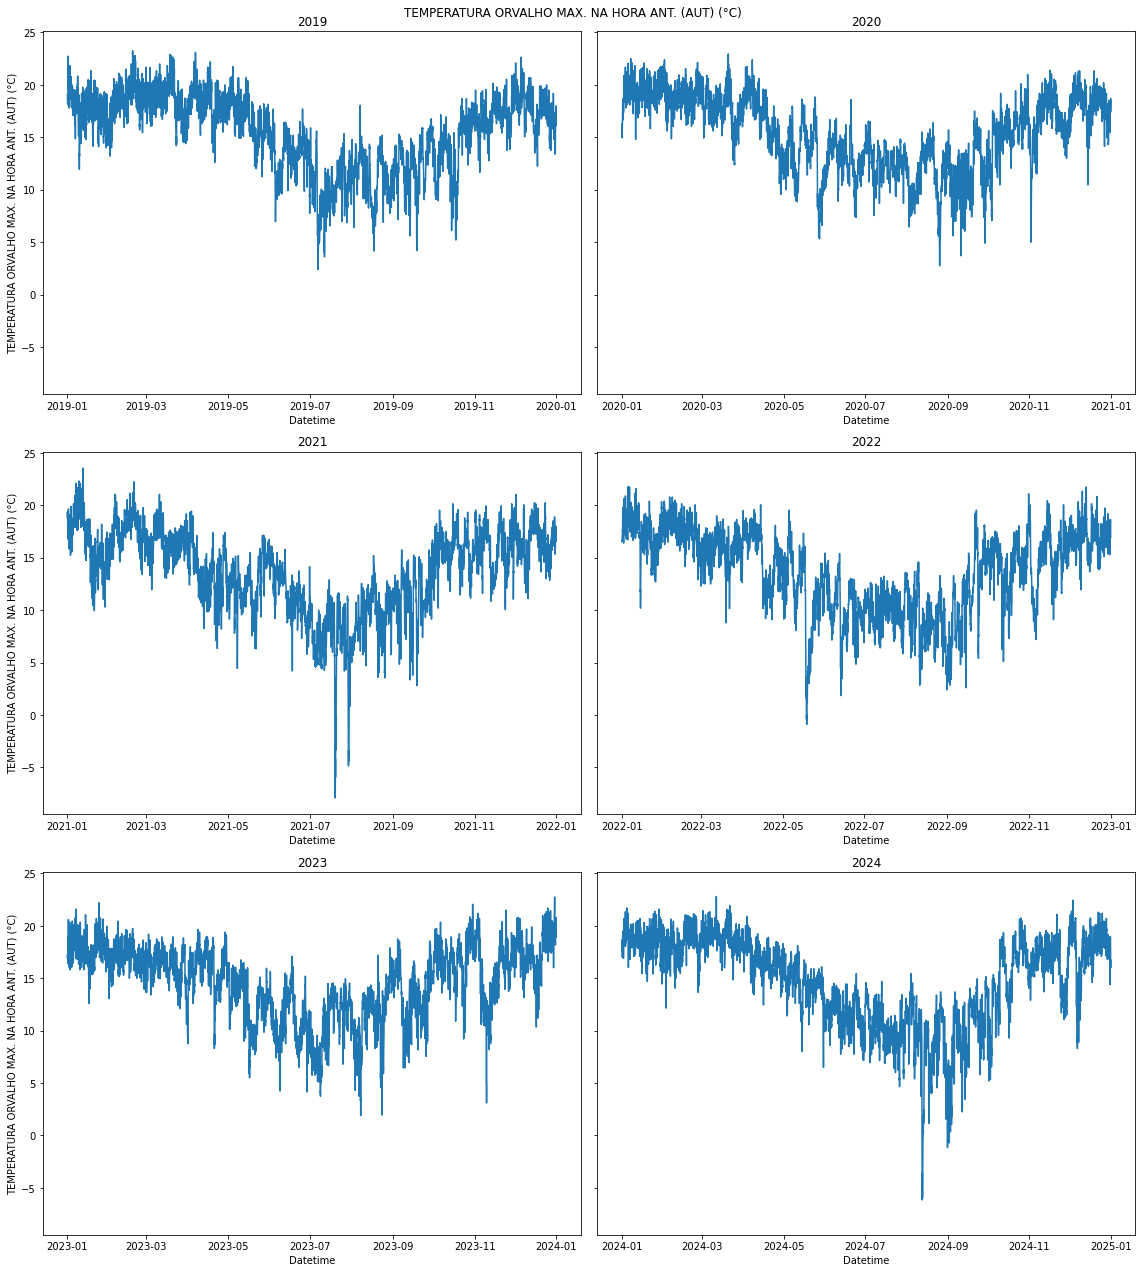

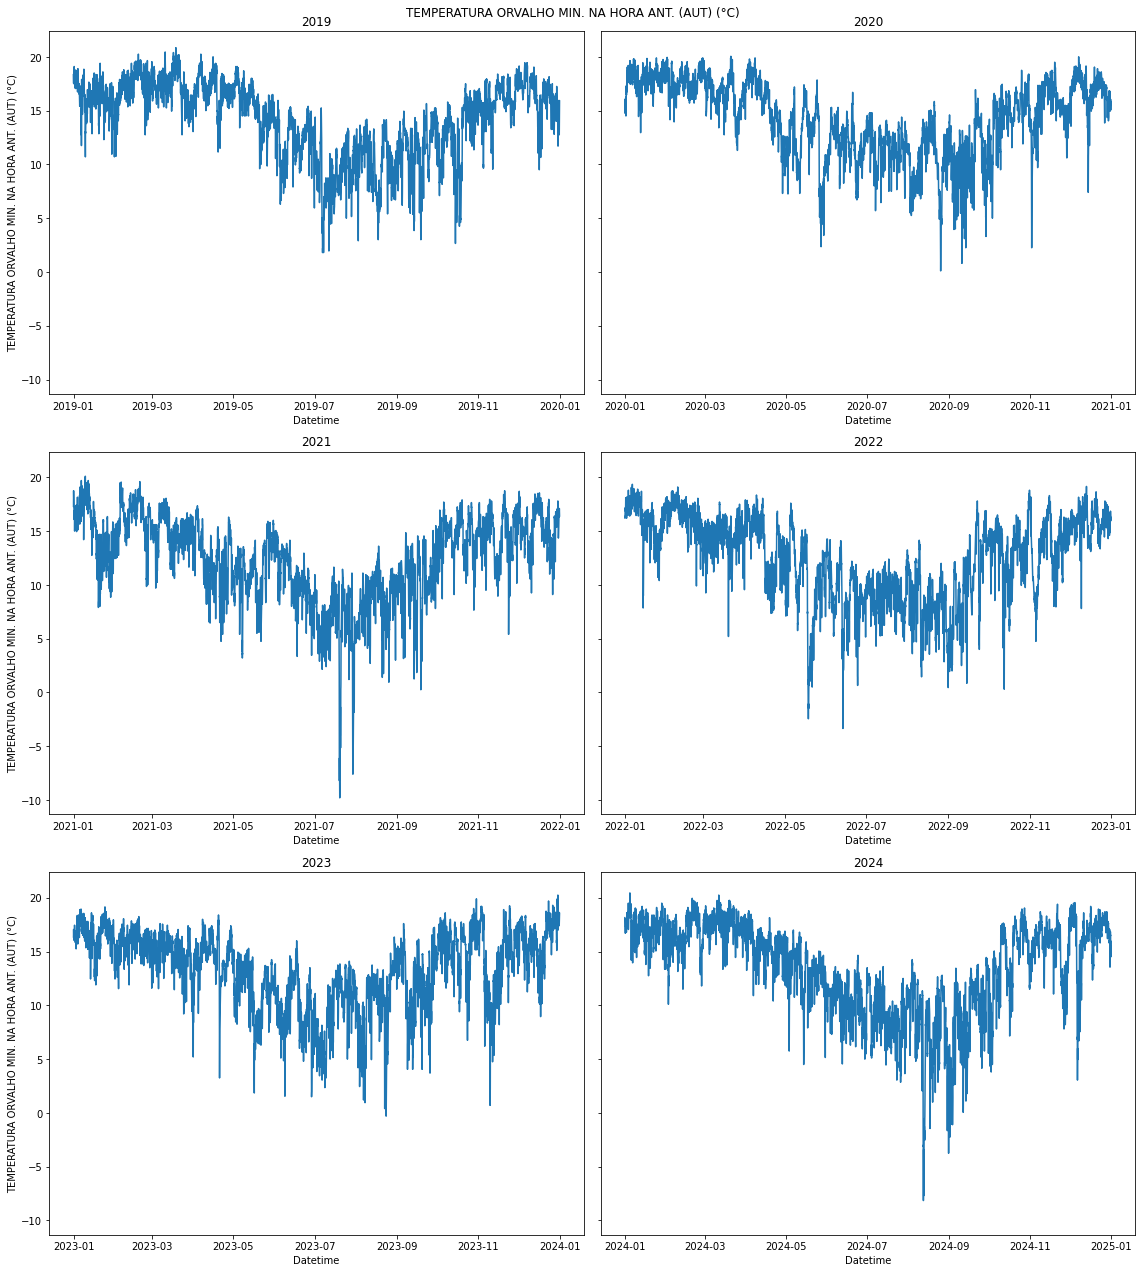

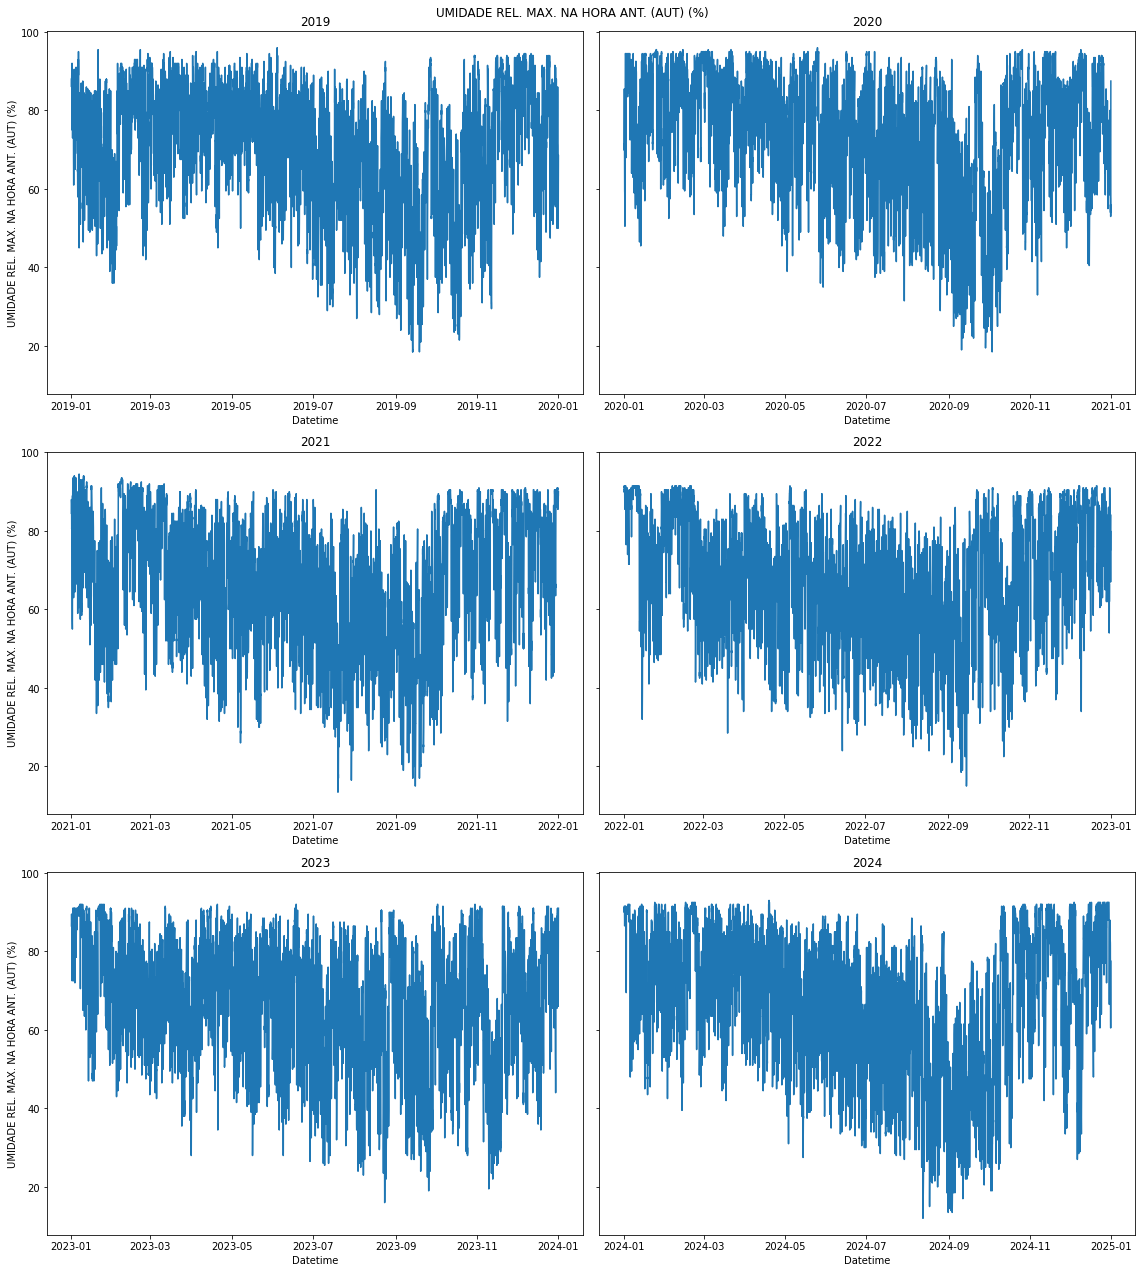

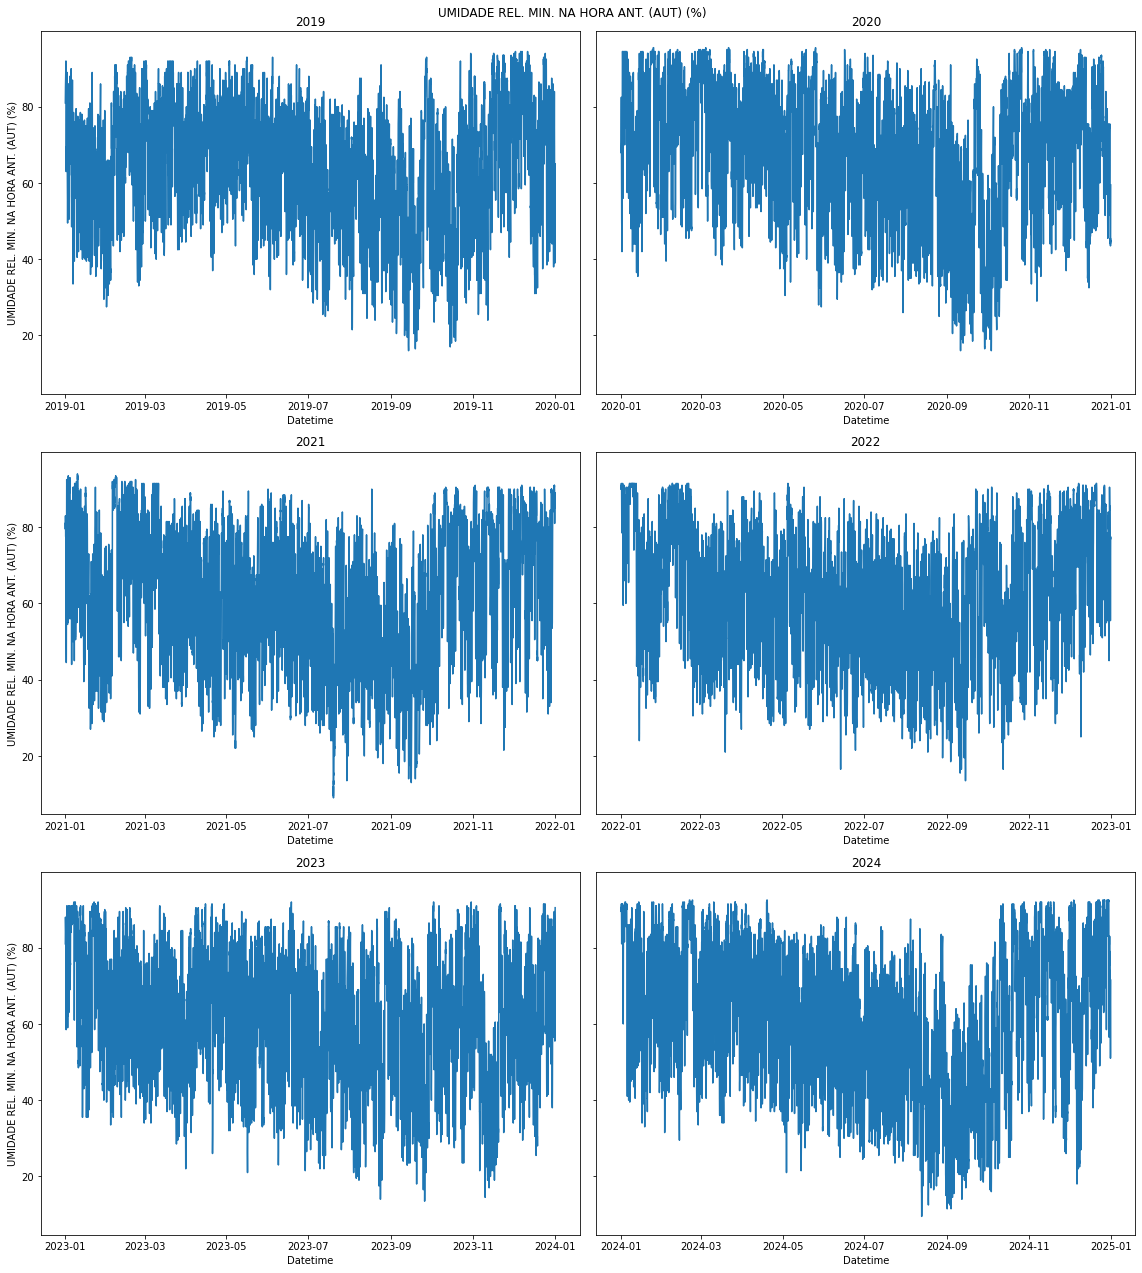

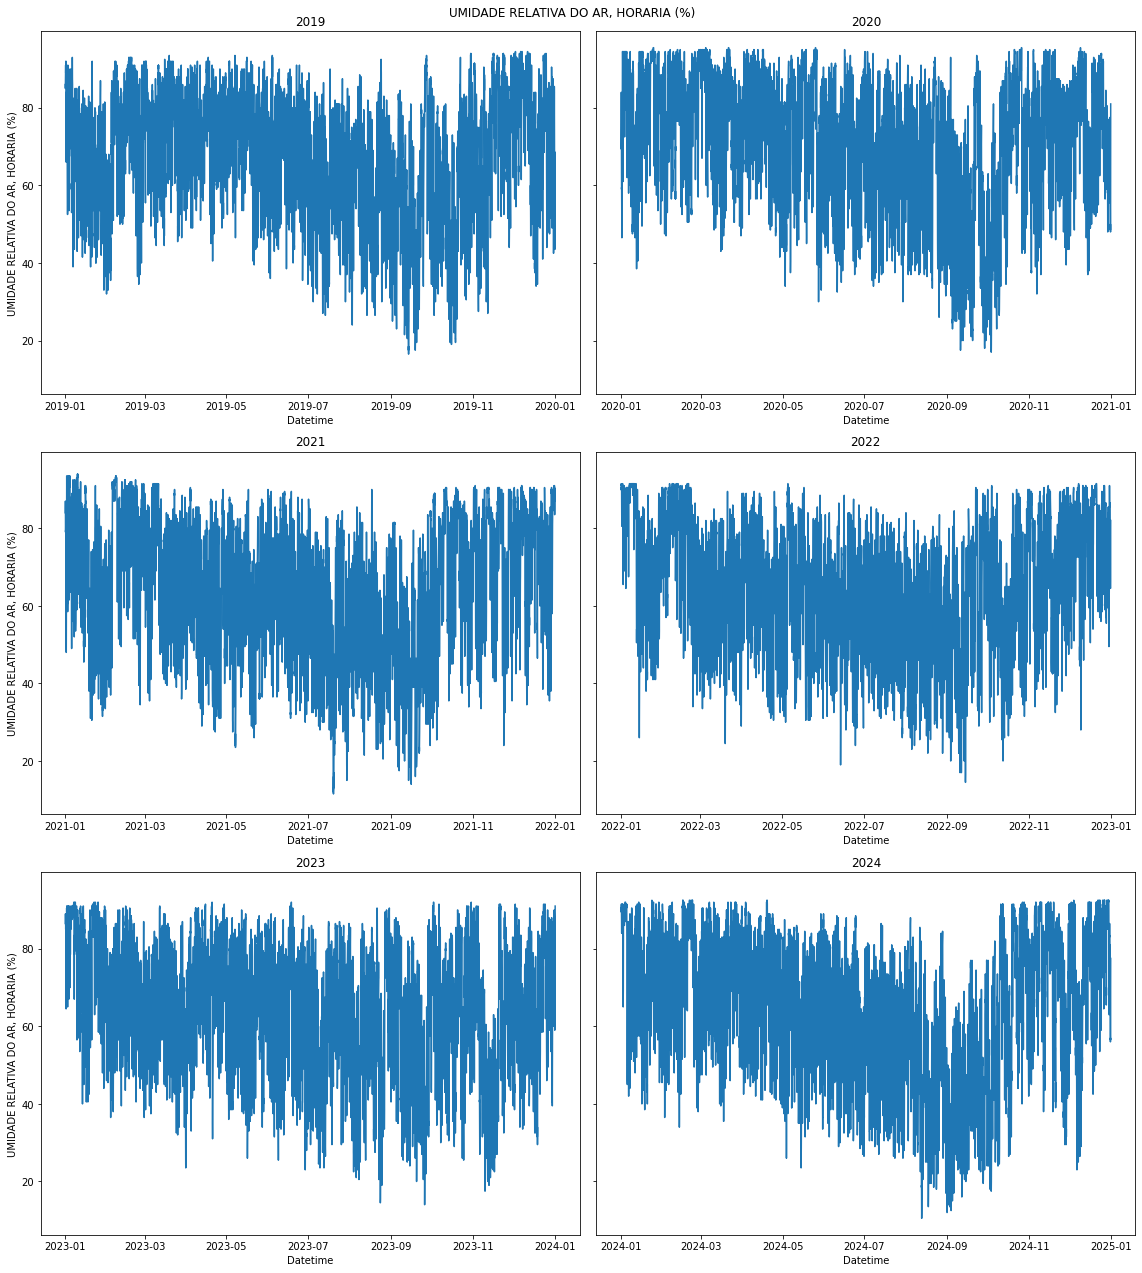

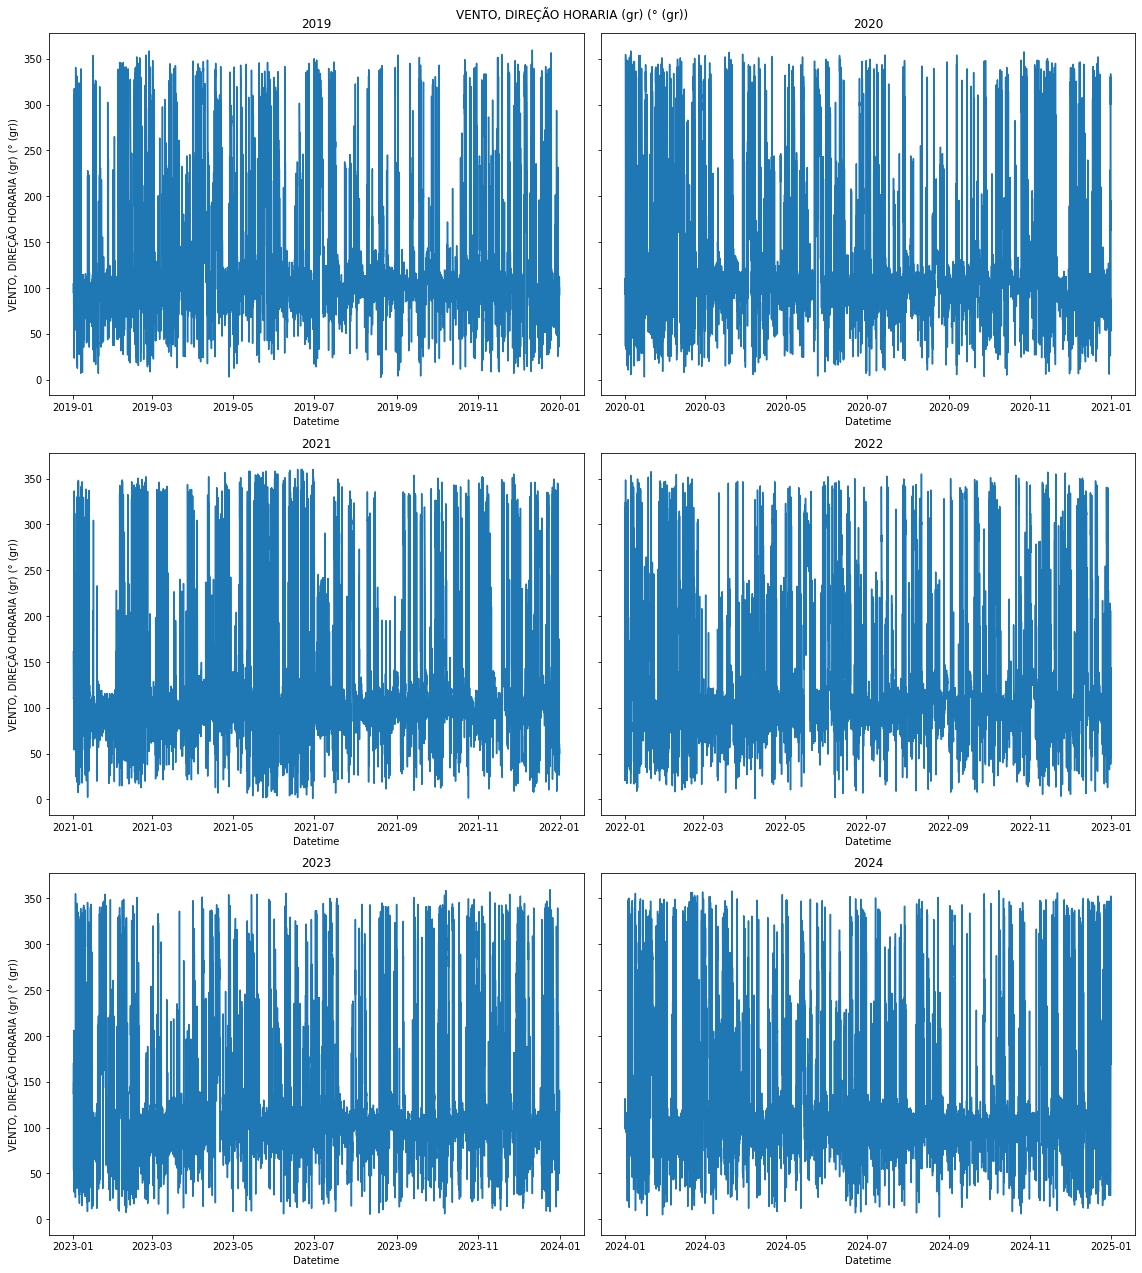

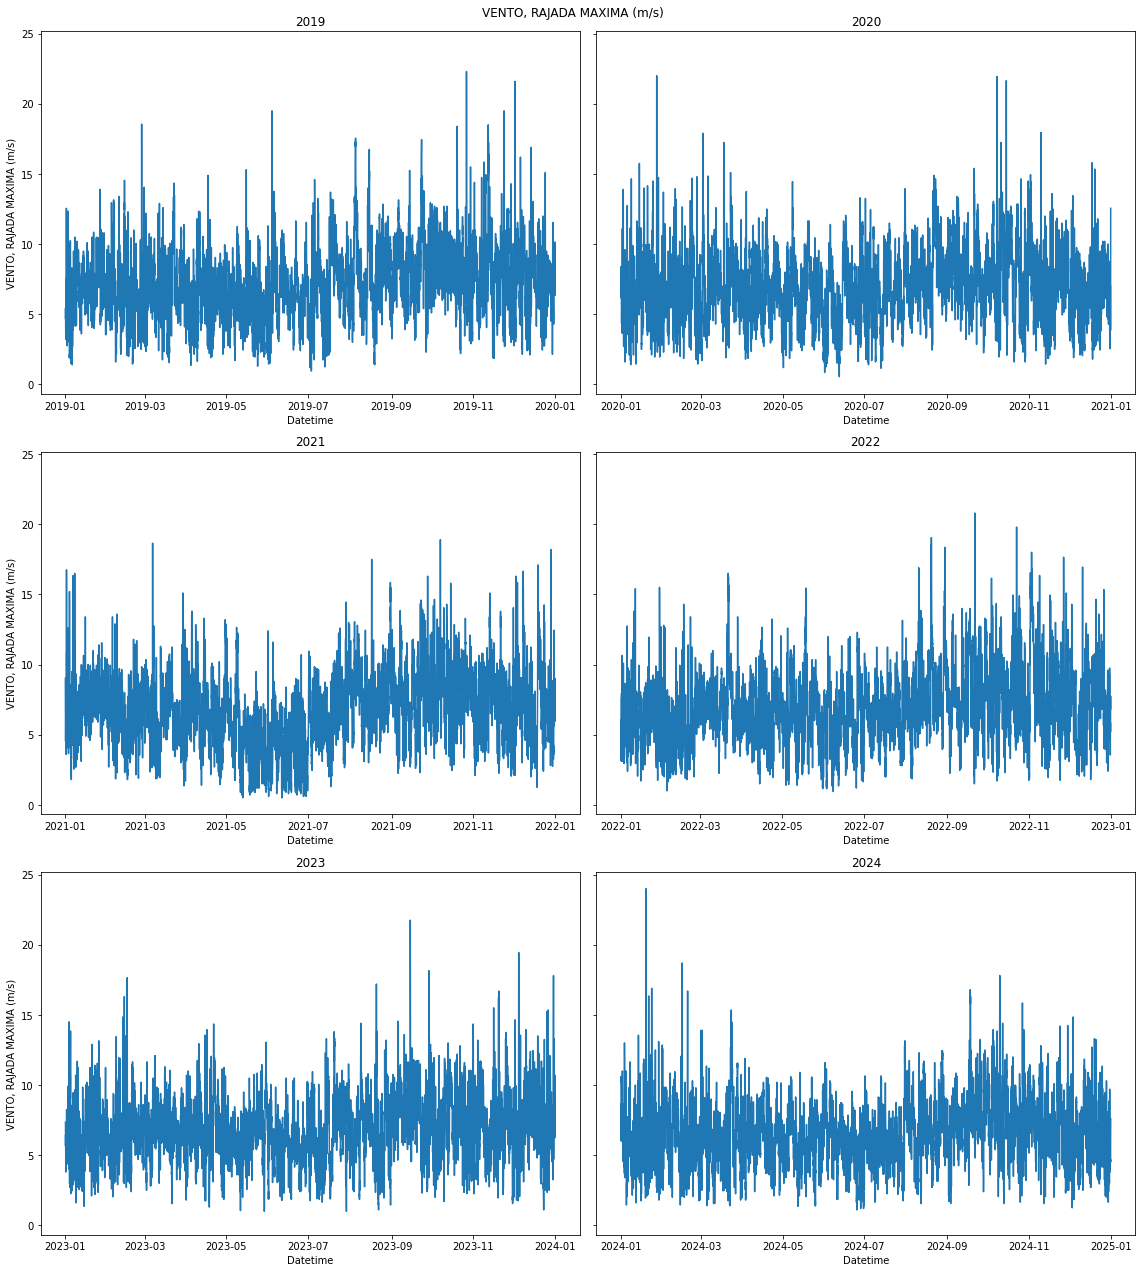

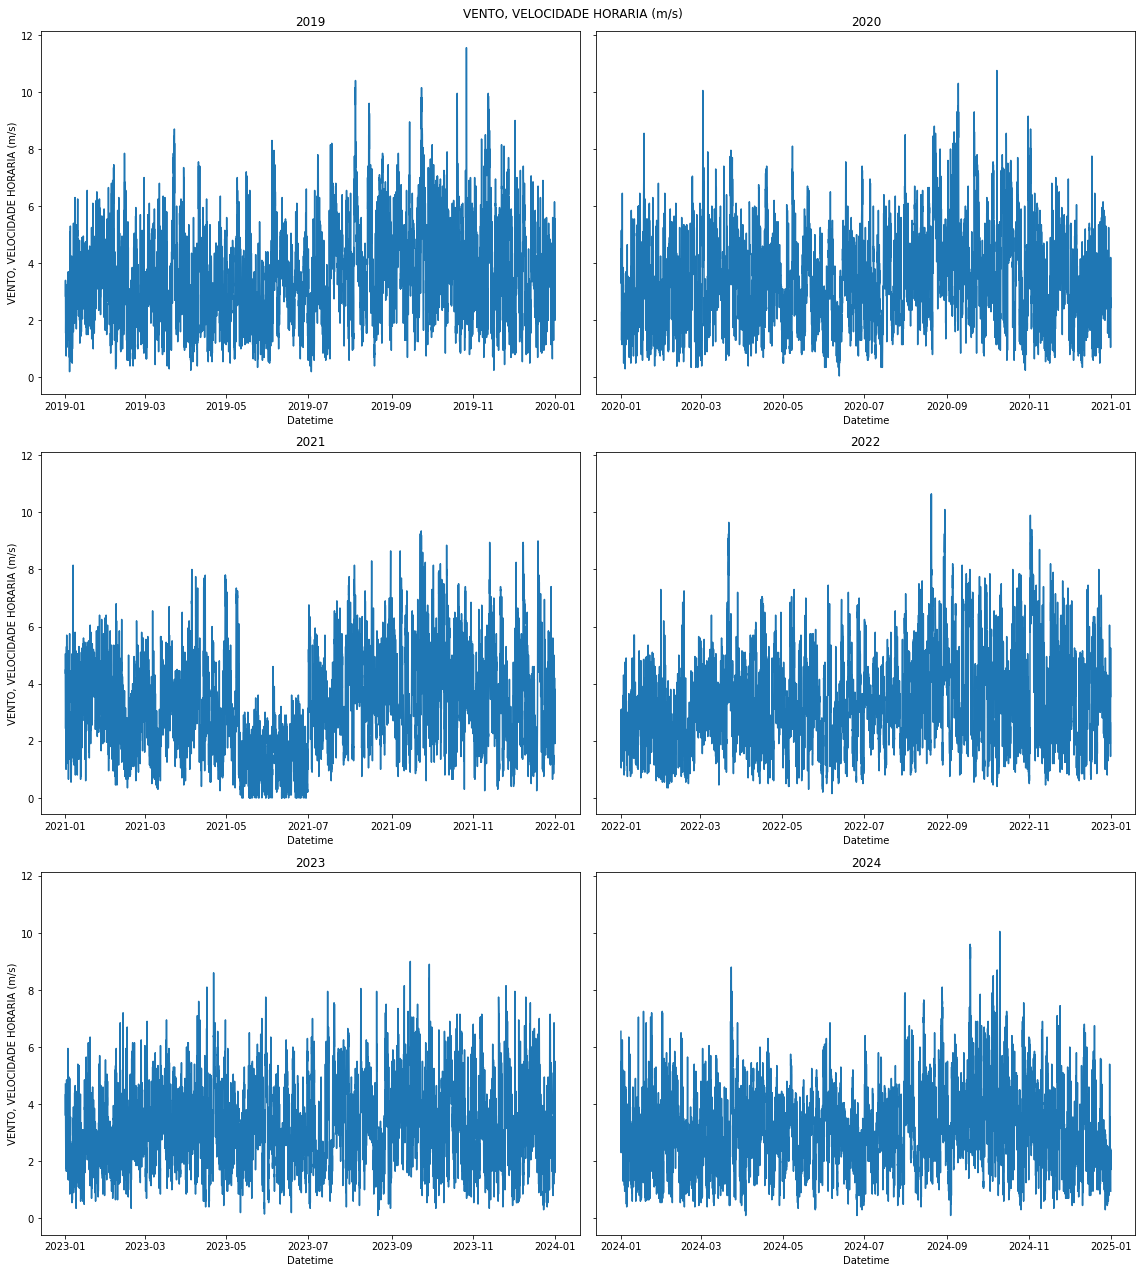

In [16]:
for col in complete_df.columns.tolist()[:-1]:
    plot_grouped_data(
        df=complete_df,
        group_col="Ano",
        value_col=col)

# Saída de Dados

In [17]:
OUTPUT_PATH = join(MODULE_PATH, "sources/processed")

In [18]:
complete_df.to_csv(join(OUTPUT_PATH, "processed_data.csv"))